# Credit Card Fraud Detection with Machine Learning

## Table of Contents

1. Introduction  
2. Imports and Setup  
3. Data Loading  
&emsp;3.1 Data Inspection  
&emsp;3.2 Column Selection, Cleanup, and Initial Feature Engineering  
4. Exploratory Data Analysis (EDA)  
&emsp;4.1 Distribution Analysis  
&emsp;&emsp;4.1.1 Descriptive Statistics of Numerical Features  
&emsp;&emsp;4.1.2 Comparative Distributions by Fraud Label  
&emsp;&emsp;4.1.3 Categorical Features by Fraud Label  
&emsp;4.2 Class Imbalance  
&emsp;4.3 Temporal Patterns  
&emsp;&emsp;4.3.1 Temporal Features from Timestamps  
&emsp;&emsp;4.3.2 Time Between Transactions  
&emsp;4.4 Spatial Patterns  
&emsp;4.5 Feature Ideation: Additional Engineered Variables  
&emsp;4.6 Correlations and Outliers  
5. Feature Engineering  
&emsp;5.1 Feature Selection  
&emsp;&emsp;5.1.1 Domain-Informed Selection  
&emsp;&emsp;5.1.2 Feature Importance via Random Forest  
&emsp;&emsp;5.1.3 Mutual Information  
&emsp;&emsp;5.1.4 Redundancy Removal and Collinearity Handling  
&emsp;5.2 Final Preprocessing Pipeline  
6. Modeling  
&emsp;6.1 Model Selection and Training (with Python)  
&emsp;&emsp;6.1.1 Random Forest  
&emsp;&emsp;6.1.2 Logistic Regression  
&emsp;&emsp;6.1.3 LightGBM  
&emsp;&emsp;6.1.4 Model Comparison  
&emsp;6.2 Evaluation Metrics  
&emsp;&emsp;6.2.1 Random Forest — Test Evaluation  
&emsp;&emsp;6.2.2 Logistic Regression — Test Evaluation  
&emsp;&emsp;6.2.3 LightGBM — Test Evaluation  
&emsp;&emsp;6.2.4 Final Comparison and Discussion  
7. Model Optimization  
&emsp;7.1 Cross-Validation Strategy  
&emsp;7.2 Hyperparameter Tuning with Grid Search  
&emsp;7.3 Evaluation After Optimization  
8. Evaluation Metrics Justification  
&emsp;8.1 Business Impact of Fraud Detection  
&emsp;8.2 Why Recall? Why Not Accuracy?  
&emsp;8.3 Precision-Recall vs AUC  
9. Handling Class Imbalance  
&emsp;9.1 Oversampling with RandomOverSampler  
&emsp;9.2 Oversampling with SMOTE  
&emsp;9.3 Summary and Comparison of Oversampling Methods  
10. Model Refinement and Interpretation  
&emsp;10.1 Threshold Tuning and Evaluation  
&emsp;10.2 Explainability and Feature Contributions  
&emsp;10.3 Business Implications and Next Steps  
11. Final Summary and Recommendations
12. Migration to PySpark   
&emsp;12.1 Exploratory Data Analysis in PySpark  
&emsp;12.2 Data Preparation in PySpark 



## 1. Introduction

This project presents a complete machine learning pipeline for detecting fraudulent credit card transactions using real-world-inspired, simulated data.

The dataset was obtained from [Kaggle: Fraud Detection Dataset](https://www.kaggle.com/datasets/kartik2112/fraud-detection), and contains over 550,000 transactions made by 1,000 customers between January 1st, 2019 and December 31st, 2020. The data includes both legitimate and fraudulent transactions, labeled via the `is_fraud` variable.

Although the dataset is synthetic, it was generated using the [Sparkov Data Generation Tool](https://github.com/BrandonHarris/sparkov-data-generation) with realistic behavior profiles for different demographics and transaction patterns. It includes detailed fields such as merchant information, transaction location, customer demographics, transaction amount, and timestamp — providing a rich context for training fraud detection models.

> **Note:** Credit card fraud detection is a highly imbalanced binary classification problem. Most transactions are legitimate, which makes appropriate evaluation metrics (e.g., precision, recall, F1-score, AUC) critical for judging model performance.

### Tools and Approach

The initial analysis and modeling are developed using Python and the Pandas library for rapid exploration and prototyping. In later stages, the data preparation pipeline is migrated to PySpark to simulate a production-scale environment and ensure the workflow is scalable to large volumes of data.

## 2. Imports and Setup

This section imports the necessary libraries and configures basic settings for data display.

In [3]:
# === Data Manipulation ===
import pandas as pd
import numpy as np

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# === Modeling & Feature Selection ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import shap

# === Evaluation Metrics ===
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    make_scorer
)

# === PySpark ===
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, count, countDistinct, avg, stddev, min, max, log1p, desc,
    to_date, hour, dayofweek, month, lag, unix_timestamp, lit, when, monotonically_increasing_id
)
from pyspark.sql.window import Window

# === PySpark ML ===
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# === Utility ===
import os
import warnings
from IPython.display import display
from math import radians, sin, cos, sqrt, atan2

# === Settings ===
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set_palette("deep")  # Ensures consistency in plots


## 3. Data Loading

This section loads the full training dataset of credit card transactions into memory and performs initial structural inspection and cleaning.

The dataset contains 23 columns, including transaction metadata, customer and merchant information, geolocation, and a binary fraud label (`is_fraud`). To prepare the data for analysis and modeling, I first inspect its structure and quality, and then retain only the most relevant features for further exploration.

### 3.1 Data Inspection

The dataset is loaded from the original CSV file, and its structure is examined for basic properties such as shape, missing values, and class distribution.

These early checks help ensure that the data is clean, well-formed, and ready for transformation and analysis.

In [2]:
# Load the full training dataset
data_path = "/Users/nina2012/Library/CloudStorage/Dropbox/Data Scientist/Job Market/Test/2025-06-30- Ifood Case/Fraud/fraudTrain.csv"
df = pd.read_csv(data_path)

# Basic shape and preview
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1296675, 23)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0])

Missing values per column:
Series([], dtype: int64)


In [4]:
# Check for duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


In [5]:
# Target class distribution
print("Fraud label distribution:")
print(df['is_fraud'].value_counts(normalize=True))

Fraud label distribution:
0    0.994211
1    0.005789
Name: is_fraud, dtype: float64


### Conclusion

The full training dataset was successfully loaded, containing 23 columns and over 550,000 transaction records.

Initial inspection revealed the following:

- There are **no missing values** in any of the columns, which simplifies the data cleaning process.
- The dataset is highly **imbalanced**, with only **0.58% of the transactions labeled as fraudulent (`is_fraud = 1`)**, which is typical for real-world fraud detection problems.
- The features include a diverse mix of **categorical, numerical, temporal, and geospatial information**, providing rich context for feature engineering.
- No duplicate rows were found, confirming the integrity of the transaction records.

Given the class imbalance, special attention will be required during model training and evaluation to avoid misleading accuracy metrics and to ensure the model captures fraudulent patterns effectively.

### 3.2 Column Selection, Cleanup, and Initial Feature Engineering

The original dataset contains 23 columns, including metadata, identifiers, and contextual information about the transaction, the customer, and the merchant.

While some of these columns are relevant for analysis and modeling, others offer little predictive value or are too granular (e.g., personal names, street addresses, or unique transaction IDs). To simplify the workflow and focus the analysis on informative variables, only a subset of relevant columns is retained.

The following columns are **excluded** from the cleaned dataset:

- `index` or `Unnamed: 0`: simple row index  
- `cc_num`: anonymized credit card number (used for feature engineering, then removed)  
- `first`, `last`: customer first and last names — not predictive  
- `street`, `city`: highly granular location details with high cardinality  
- `trans_num`: unique transaction ID  
- `unix_time`: redundant with `trans_date_trans_time`  

The cleaned dataset retains variables related to transaction time and amount, customer demographics and location, merchant information, and the fraud label. Additionally, several engineered features are added to capture temporal, geographic, and behavioral patterns:

- **`age`**: calculated from the customer's date of birth and the transaction timestamp.  
- **`hour`, `day_of_week`, and `month`**: extracted from the transaction timestamp to capture time-based fraud patterns.  
- **`distance`**: physical distance (in kilometers) between customer and merchant, calculated using the Haversine formula.  
- **`time_since_last_transaction`**: time elapsed (in seconds) since the customer’s previous transaction.  
- **`distance_delta`**: change in transaction distance relative to the previous transaction (per customer).  
- **`daily_txn_count`**: number of transactions by the customer on the same day.  
- **`time_since_first_txn_today`**: seconds since the first transaction of the day for the customer.  
- **`avg_amt_by_user`**: average transaction amount for each customer.  
- **`relative_amt_zip` and `relative_amt_state`**: the transaction amount divided by the median amount in the same ZIP code or state.  
- **`merchant_popularity`**: total number of transactions associated with each merchant.  
- **`merchant_freq`**: number of times the customer has transacted with that specific merchant.  
- **`is_high_value`**: dummy flag for transactions above the 95th percentile in value.  
- **`known_merchant`**: dummy flag indicating whether the customer has transacted with the same merchant before.

These engineered features are designed to enrich the dataset with contextual and behavioral signals that may enhance fraud detection performance in downstream modeling.

In [6]:
def basic_cleaning(df):
    """
    Basic preprocessing: select relevant columns, parse dates,
    and derive engineered features like age, temporal attributes,
    customer–merchant distance, and multiple behavioral/contextual features.
    """
    cols_to_keep = [
        'trans_date_trans_time', 'amt', 'category', 'merchant',
        'gender', 'city_pop', 'job', 'dob', 'state', 'zip',
        'lat', 'long', 'merch_lat', 'merch_long', 'cc_num', 'is_fraud'
    ]
    df = df[cols_to_keep].copy()

    # Convert to datetime
    df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

    # Derive age
    df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year
    df.drop(columns='dob', inplace=True)

    # Temporal features
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['month'] = df['trans_date_trans_time'].dt.month
    df['date'] = df['trans_date_trans_time'].dt.date

    # Haversine distance
    def haversine(row):
        R = 6371
        lat1, lon1 = radians(row['lat']), radians(row['long'])
        lat2, lon2 = radians(row['merch_lat']), radians(row['merch_long'])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        return R * c

    df['distance'] = df.apply(haversine, axis=1)

    # Sort and compute features per customer
    df.sort_values(by=['cc_num', 'trans_date_trans_time'], inplace=True)
    df['time_since_last_transaction'] = df.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds()
    df['distance_delta'] = df.groupby('cc_num')['distance'].diff().abs()

    # Daily transaction count per customer
    df['daily_txn_count'] = df.groupby(['cc_num', 'date'])['amt'].transform('count')

    # Time since first transaction today
    df['time_since_first_txn_today'] = df.groupby(['cc_num', 'date'])['trans_date_trans_time'].transform(
        lambda x: (x - x.min()).dt.total_seconds()
    )

    # Average transaction amount per customer
    df['avg_amt_by_user'] = df.groupby('cc_num')['amt'].transform('mean')

    # Relative amount to ZIP and State medians
    df['relative_amt_zip'] = df['amt'] / df.groupby('zip')['amt'].transform('median')
    df['relative_amt_state'] = df['amt'] / df.groupby('state')['amt'].transform('median')

    # Merchant popularity (overall)
    df['merchant_popularity'] = df.groupby('merchant')['amt'].transform('count')

    # Merchant frequency for this customer
    df['merchant_freq'] = df.groupby(['cc_num', 'merchant'])['amt'].transform('count')

    # High-value transaction dummy
    high_value_threshold = df['amt'].quantile(0.95)
    df['is_high_value'] = (df['amt'] > high_value_threshold).astype(int)

    # Known merchant dummy (based on previous interactions)
    df['known_merchant'] = df.duplicated(subset=['cc_num', 'merchant']).astype(int)

    # Drop helper columns
    df.drop(columns=['cc_num', 'date'], inplace=True)

    return df


In [7]:
df_train = basic_cleaning(pd.read_csv("fraudTrain.csv"))

## 4. Exploratory Data Analysis (EDA)

In this section, I explore the dataset in depth to understand the distribution, behavior, and structure of key features. This analysis helps guide feature engineering and model design by identifying patterns, trends, outliers, and potential data quality issues.

Given the complexity of fraud detection — especially under severe class imbalance — visual and statistical exploration is crucial for uncovering any meaningful separation between fraudulent and legitimate transactions.

The EDA is structured into the following parts:

- 4.1 Univariate Analysis
- 4.2 Class Imbalance
- 4.3 Temporal Patterns
- 4.4 Spatial Patterns
- 4.5 Correlations and Outliers

### 4.1 Distribution Analysis

This subsection examines the distribution of individual features, starting with key numerical variables such as transaction amount, city population, customer age, and gender.

Understanding the range, central tendency, and skewness of these variables provides insight into general user behavior and helps inform preprocessing decisions, such as feature scaling or transformation. This exploration also supports identifying potential visual differences between fraudulent and legitimate transactions.


#### 4.1.1 Descriptive Statistics of Numerical Features

Before generating visualizations, it is useful to examine descriptive statistics for key numerical variables in the dataset. This step helps identify distributional properties, detect skewness, and guide appropriate scaling or transformation strategies.

The following variables are included:
- `amt`: transaction amount
- `city_pop`: customer’s city population
- `age`: derived from date of birth and transaction timestamp
- `lat` / `long`: customer geographic coordinates

In [8]:
# Select numerical features for summary
numeric_cols = ['amt', 'city_pop', 'age', 'lat', 'long']

# Compute descriptive statistics
desc_stats = df_train[numeric_cols].describe().T

# Add skewness
desc_stats['skew'] = df_train[numeric_cols].skew()

# Display
desc_stats

,count,mean,std,min,25%,50%,75%,max,skew
amt,1296675.0,70.351035,160.316039,1.0000,9.6500,47.5200,83.1400,2.894890e+04,42.277874
city_pop,1296675.0,88824.440563,301956.360689,23.0000,743.0000,2456.0000,20328.0000,2.906700e+06,5.593853
age,1296675.0,46.029298,17.382373,14.0000,33.0000,44.0000,57.0000,9.600000e+01,0.612262
lat,1296675.0,38.537622,5.075808,20.0271,34.6205,39.3543,41.9404,6.669330e+01,-0.186028
long,1296675.0,-90.226335,13.759077,-165.6723,-96.7980,-87.4769,-80.1580,-6.795030e+01,-1.150108


#### Conclusion - Descriptive Statistics of Numerical Features

The descriptive statistics reveal key characteristics of the main numerical features in the dataset:

- **Transaction amount (`amt`)** is highly skewed to the right, with a maximum value near $29,000 and a skewness of **42.28**. Most transactions are under $100, suggesting that a log transformation may improve both visualization and model performance.
  
- **City population (`city_pop`)** also exhibits strong right skew (**5.59**), with most customers residing in small towns (median ≈ 2,456) and a few in cities over 2.9 million people.

- **Customer age (`age`)** ranges from 14 to 96 years, with a fairly symmetric distribution (skew ≈ 0.61) centered around a mean of 46. This feature appears usable in its current form.

- **Latitude and longitude (`lat`, `long`)** show a plausible geographic distribution across the U.S. The slight left skew in `long` suggests more customers are located in the eastern half of the country.

These findings support the use of log-scaling for `amt` and `city_pop`, while confirming `age` as a stable and interpretable feature for downstream modeling.

### 4.2 Comparative Distributions by Fraud Label

To better understand how fraudulent transactions differ from legitimate ones, this section compares the distributions of selected numerical variables across the two classes of the target variable `is_fraud`.

By visualizing how features like transaction amount, city population, and customer age vary between fraud and non-fraud cases, it becomes easier to identify potential predictors and inform feature engineering decisions.

The following plots show the distributions of:
- `amt` (Transaction amount, log-transformed for visibility)
- `city_pop` (Customer’s city population, log-transformed)
- `age` (Derived from date of birth)

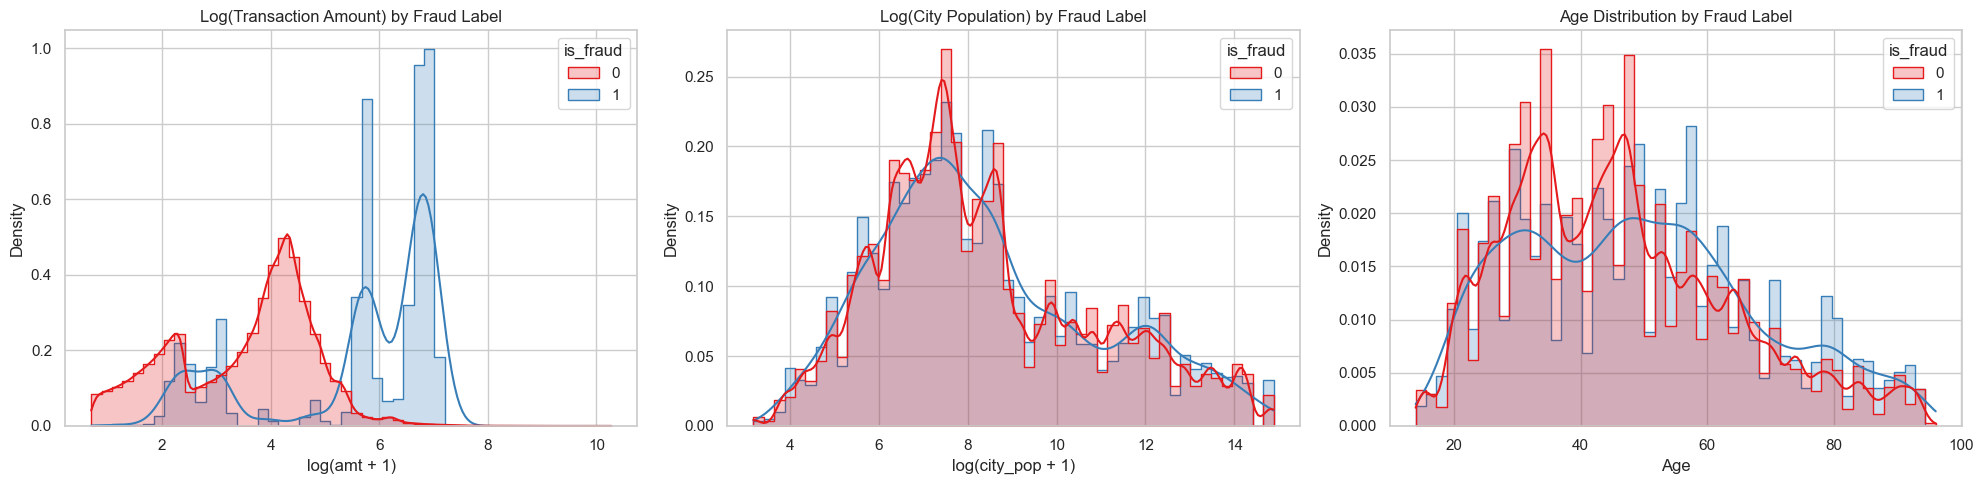

In [9]:
# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# 1. Transaction amount (log-transformed)
sns.histplot(
    data=df_train,
    x=np.log1p(df_train['amt']),
    hue='is_fraud',
    bins=50,
    stat='density',
    kde=True,
    element='step',
    common_norm=False,
    ax=axs[0],
    palette='Set1'
)
axs[0].set_title("Log(Transaction Amount) by Fraud Label")
axs[0].set_xlabel("log(amt + 1)")

# 2. City population (log-transformed)
sns.histplot(
    data=df_train,
    x=np.log1p(df_train['city_pop']),
    hue='is_fraud',
    bins=50,
    stat='density',
    kde=True,
    element='step',
    common_norm=False,
    ax=axs[1],
    palette='Set1'
)
axs[1].set_title("Log(City Population) by Fraud Label")
axs[1].set_xlabel("log(city_pop + 1)")

# 3. Age
sns.histplot(
    data=df_train,
    x='age',
    hue='is_fraud',
    bins=50,
    stat='density',
    kde=True,
    element='step',
    common_norm=False,
    ax=axs[2],
    palette='Set1'
)
axs[2].set_title("Age Distribution by Fraud Label")
axs[2].set_xlabel("Age")

plt.tight_layout()
plt.show()


#### Conclusion — Comparative Distributions by Fraud Label

These density plots compare the distribution of three key features — transaction amount, city population, and customer age — between fraudulent and legitimate transactions. Several interesting patterns emerge:

- **Transaction Amount**: Fraudulent transactions tend to have higher amounts than legitimate ones, with noticeable density peaks around \$400 and above \$1,000. This supports the intuition that fraud often targets higher-value transactions. The difference in distribution is particularly sharp in the higher tail.

- **City Population**: The distribution of city population is quite similar across both classes. However, there is a slight shift suggesting that fraudulent transactions may occur slightly more frequently in larger cities. Still, this variable alone may not offer strong predictive power.

- **Customer Age**: Fraudulent transactions appear more frequent among older customers, particularly those above 60 years old. This could reflect targeted exploitation of certain demographic groups or less vigilant monitoring of older accounts.

These findings highlight that **transaction amount** and **customer age** may be strong discriminative features for fraud detection and merit further attention during feature engineering and modeling.


#### 4.1.3 Categorical Feature Distributions and Fraud Profiles

In this subsection, I explore the distribution of key categorical variables — such as `gender`, `category`, and `job` — to assess their relationship with the fraud label (`is_fraud`).

For `gender` and `category`, I compare the frequency of each category across both fraudulent and legitimate transactions, using grouped bar plots. This highlights potential imbalances or risk patterns associated with specific groups.

For the `job` feature, I focus **only on the top 10 occupations among fraudulent transactions**, as the number of non-fraud cases is overwhelmingly larger. This targeted view helps surface patterns that may otherwise be obscured by class imbalance. A comparative analysis with legitimate cases could be explored in future steps, but the current focus is on identifying suspicious behavior profiles.

These insights are useful both for understanding fraud dynamics and for informing feature encoding strategies in the modeling phase.

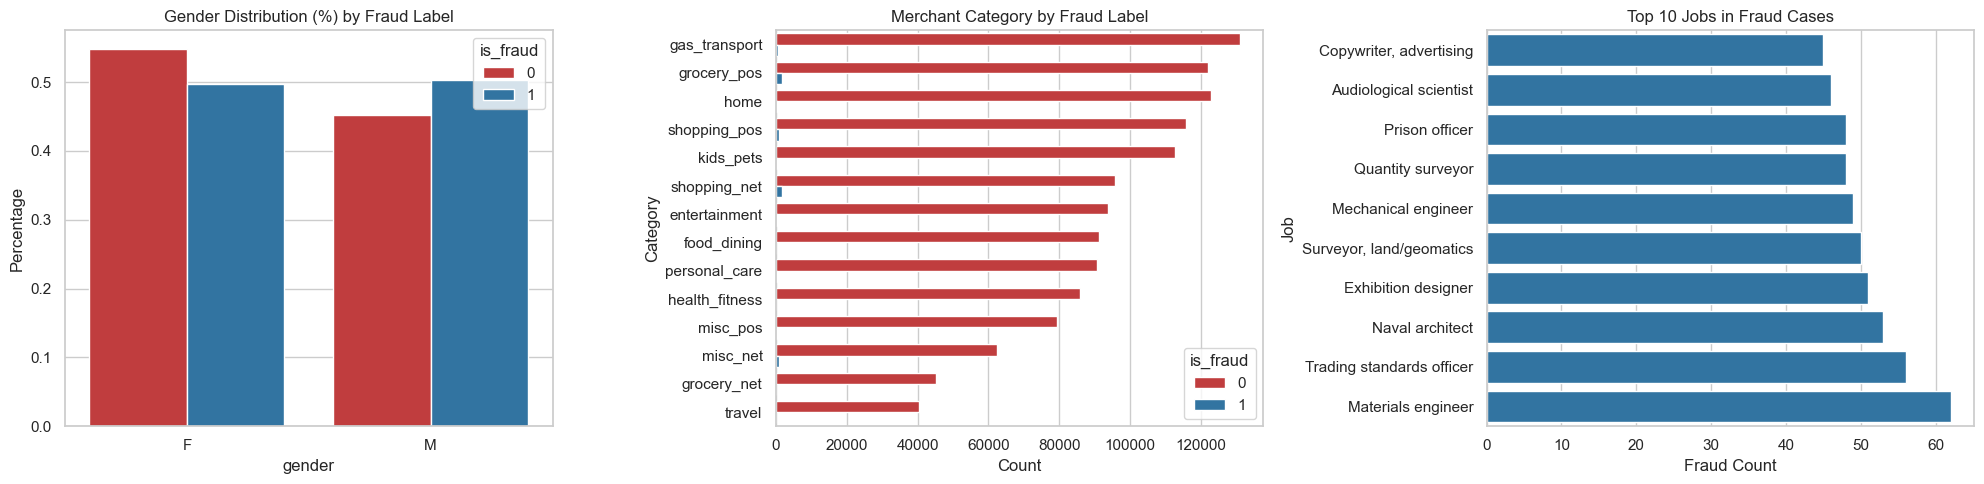

In [10]:
# Define color palette
palette = {0: "#d62728", 1: "#1f77b4"}

# Set up the layout
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# --- 1. Gender distribution (percentage by class) ---
gender_dist = (
    df_train.groupby("is_fraud")["gender"].value_counts(normalize=True)
    .rename("percentage")
    .reset_index()
)
sns.barplot(
    data=gender_dist,
    x="gender",
    y="percentage",
    hue="is_fraud",
    palette=palette,
    ax=axs[0]
)
axs[0].set_title("Gender Distribution (%) by Fraud Label")
axs[0].set_ylabel("Percentage")
axs[0].legend(title="is_fraud")

# --- 2. Merchant category count by class ---
sns.countplot(
    data=df_train,
    y="category",
    hue="is_fraud",
    palette=palette,
    order=df_train["category"].value_counts().index,
    ax=axs[1]
)
axs[1].set_title("Merchant Category by Fraud Label")
axs[1].set_xlabel("Count")
axs[1].set_ylabel("Category")
axs[1].legend(title="is_fraud")

# --- 3. Top 10 jobs in fraud cases ---
top_jobs = (
    df_train[df_train["is_fraud"] == 1]["job"]
    .value_counts()
    .head(10)
    .sort_values()
)
sns.barplot(
    x=top_jobs.values,
    y=top_jobs.index,
    color=palette[1],
    ax=axs[2]
)
axs[2].set_title("Top 10 Jobs in Fraud Cases")
axs[2].set_xlabel("Fraud Count")
axs[2].set_ylabel("Job")

# Layout adjustment
plt.tight_layout()
plt.show()

#### Conclusion – Categorical Features by Fraud Label

- **Gender:** Fraudulent transactions are extremely rare across both genders, but the majority of transactions — fraudulent or not — come from female customers. Due to the severe class imbalance, visual interpretation of fraud rates by gender remains inconclusive.

- **Merchant Category:** Fraud cases are not uniformly distributed across merchant categories. Categories such as `gas_transport`, `shopping_pos`, and `grocery_pos` appear more exposed to fraud activity, possibly due to high transaction volume or susceptibility to impersonation.

- **Job Titles:** Among fraudulent transactions, certain job titles appear disproportionately often. Professions such as *Naval architect*, *Exhibition designer*, and *Surveyor, land/geomatics* are overrepresented. While this could be coincidental or an artifact of data simulation, it may also reflect synthetic profiles or suspicious behavioral patterns worth further investigation.

These categorical insights can inform encoding strategies and help prioritize features that are potentially valuable for fraud detection modeling.

### 4.2 Class Imbalance

As previously noted in the data loading section, the dataset is highly imbalanced: only **0.58%** of the transactions are labeled as fraudulent.

This kind of class imbalance is typical in real-world fraud detection tasks and must be addressed during the modeling phase. Standard accuracy metrics can be misleading in such scenarios, as a model that predicts only the majority class could still achieve >99% accuracy.

To build an effective fraud detection model, I will consider strategies such as:
- Using evaluation metrics more sensitive to the minority class (e.g., precision, recall, F1-score, ROC AUC).
- Potentially applying resampling techniques (e.g., oversampling fraud cases) or class weighting during model training.

In [11]:
# Target class distribution
print("Fraud label distribution:")
print(df['is_fraud'].value_counts(normalize=True))

Fraud label distribution:
0    0.994211
1    0.005789
Name: is_fraud, dtype: float64


### 4.3 Temporal Patterns

Understanding how fraudulent transactions vary over time can reveal important behavioral trends. Fraudsters may target specific periods, such as weekends, nighttime hours, or certain months — or may attempt multiple transactions in quick succession.

In this section, I explore temporal patterns using both:
- **Timestamp-derived features** such as day of the week, hour of the day, and month
- **Inter-transaction timing**, measured by the number of seconds since a customer’s previous transaction

These features help reveal time-based fraud strategies, highlight operational vulnerabilities, and may inform future feature engineering or risk-based rules.

#### 4.3.1 Periodicity of Fraud

This subsection investigates fraud variation across:

- **Day of the week** (`day_of_week`)
- **Hour of the day** (`hour`)
- **Month** (`month`)

These features may reveal time-based fraud strategies or operational vulnerabilities (e.g., weekends or off-peak hours).

*A conclusão específica para esta subseção viria logo após os gráficos.*

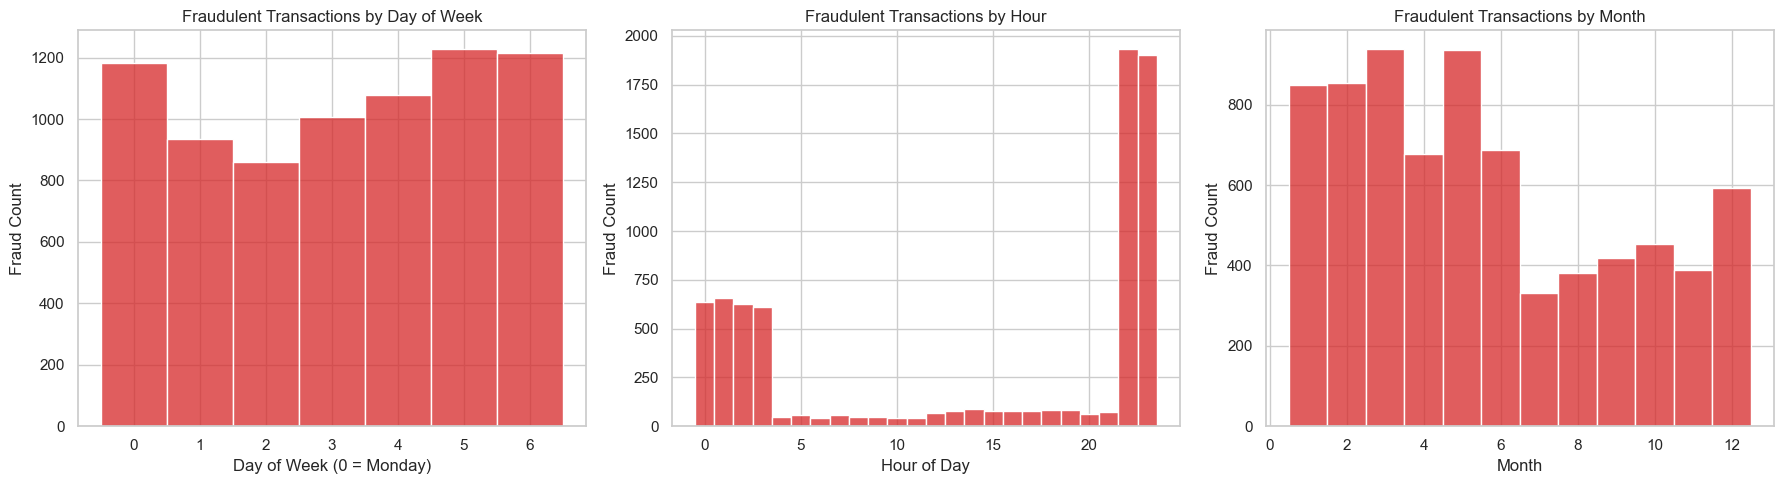

In [12]:
# Set style
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Day of Week
sns.histplot(
    data=df_train[df_train['is_fraud'] == 1],
    x='day_of_week',
    bins=7,
    discrete=True,
    ax=axs[0],
    color='#d62728'
)
axs[0].set_title("Fraudulent Transactions by Day of Week")
axs[0].set_xlabel("Day of Week (0 = Monday)")
axs[0].set_ylabel("Fraud Count")

# Hour of Day
sns.histplot(
    data=df_train[df_train['is_fraud'] == 1],
    x='hour',
    bins=24,
    discrete=True,
    ax=axs[1],
    color='#d62728'
)
axs[1].set_title("Fraudulent Transactions by Hour")
axs[1].set_xlabel("Hour of Day")
axs[1].set_ylabel("Fraud Count")

# Month
sns.histplot(
    data=df_train[df_train['is_fraud'] == 1],
    x='month',
    bins=12,
    discrete=True,
    ax=axs[2],
    color='#d62728'
)
axs[2].set_title("Fraudulent Transactions by Month")
axs[2].set_xlabel("Month")
axs[2].set_ylabel("Fraud Count")

plt.tight_layout()
plt.show()

#### Conclusion – Temporal Patterns

- **Day of the Week:** Fraudulent transactions are relatively evenly distributed across the week, with a slight increase from **Friday to Sunday**. This may reflect behavioral patterns or operational vulnerabilities during weekends.

- **Hour of the Day:** There is a **bimodal concentration** of fraudulent activity. A first peak occurs during the **early morning hours (midnight to 3 AM)**, and a second around **9–11 PM**, while daytime hours see significantly fewer fraud cases. This could suggest automated attacks during off-peak periods or reduced human oversight.

- **Month:** Fraud cases fluctuate moderately across months, with **March and May** showing slightly elevated activity. Although some seasonal variation may exist, further context is needed to assess whether this is meaningful or due to simulation artifacts.

These insights support the inclusion of temporal features—such as hour and day of the week—as potential predictors to help the model capture behavioral patterns in fraudulent activity.

#### 4.3.2 Time Since Last Transaction

Here, I analyze the variable **`time_since_last_transaction`**, which captures the time interval (in seconds) since a customer's previous transaction. Extremely short intervals may indicate bursts of automated fraudulent activity or card testing behavior.



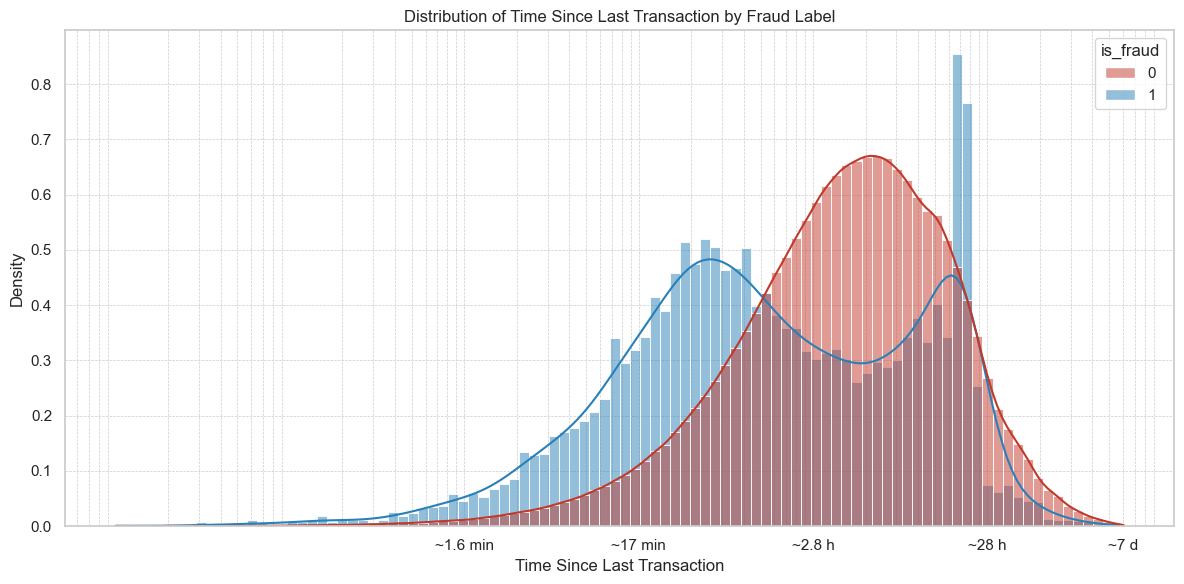

In [13]:
# Filter valid values
valid_df = df_train[
    (df_train["time_since_last_transaction"].notna()) &
    (np.isfinite(df_train["time_since_last_transaction"])) &
    (df_train["time_since_last_transaction"] > 0) &
    (df_train["time_since_last_transaction"] <= 604800)  # up to 7 days
]

# Plot with log scale on x-axis
plt.figure(figsize=(12, 6))
sns.histplot(
    data=valid_df,
    x="time_since_last_transaction",
    hue="is_fraud",
    bins=100,
    kde=True,
    stat="density",
    common_norm=False,
    palette={0: "#c0392b", 1: "#2980b9"},
    alpha=0.5,
    log_scale=(True, False)
)

plt.xticks(
    [1e2, 1e3, 1e4, 1e5, 6e5],
    ['~1.6 min', '~17 min', '~2.8 h', '~28 h', '~7 d']
)
plt.xlabel("Time Since Last Transaction")
plt.ylabel("Density")
plt.title("Distribution of Time Since Last Transaction by Fraud Label")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

#### Conclusion – Time Since Last Transaction

The distribution of time elapsed since the previous transaction reveals distinct behavioral patterns for fraud versus non-fraud cases.

- **Fraudulent transactions** tend to occur in **quick succession**, with a pronounced peak in the first few minutes following a previous transaction. This likely reflects burst activity, such as account takeovers or repeated unauthorized attempts.
- **Legitimate transactions** exhibit a broader spread, with activity peaking between several hours and one day — indicative of typical user behavior.

While there is some overlap between the classes, the difference in temporal cadence is noticeable. This engineered feature, `time_since_last_transaction`, shows promising discriminatory power and may enhance predictive performance when combined with other contextual variables.


### 4.4 Spatial Patterns

Fraudulent transactions may exhibit geographic patterns, either due to targeting of specific locations or anomalies in customer–merchant proximity. Spatial analysis can uncover:

- Unusual distances between customer and merchant
- Fraud concentration in specific regions or states

In this section, I explore spatial patterns using the following geolocation features:

- **Customer location:** latitude (`lat`) and longitude (`long`)
- **Merchant location:** latitude (`merch_lat`) and longitude (`merch_long`)
- **State:** customer’s home state

Additionally, I compute the **distance between the customer and the merchant** as a proxy for physical proximity. Extreme distances may indicate suspicious behavior, such as remote impersonation or account takeover.

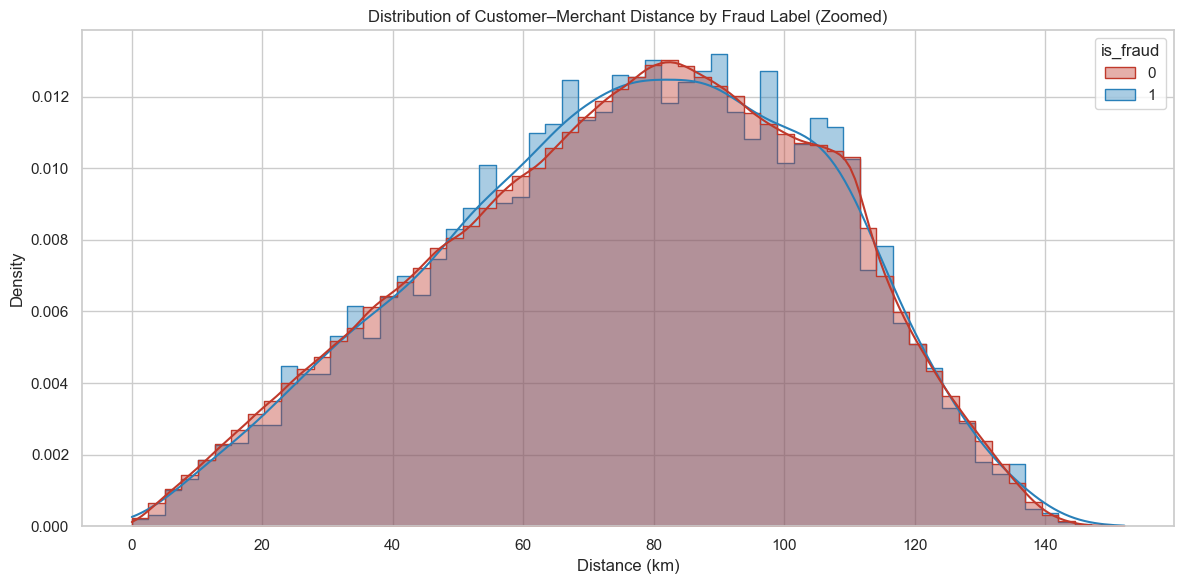

In [14]:
# Plot zoomed-in distance distribution (<= 200 km)
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_train[df_train["distance"] <= 200],
    x="distance",
    hue="is_fraud",
    kde=True,
    stat="density",
    common_norm=False,
    element="step",
    bins=60,
    palette={0: "#c0392b", 1: "#2980b9"},
    alpha=0.4
)

plt.title("Distribution of Customer–Merchant Distance by Fraud Label (Zoomed)")
plt.xlabel("Distance (km)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusion – Spatial Patterns

- The distribution of distances between customers and merchants is **similarly shaped** for both fraudulent and legitimate transactions, with most activity concentrated around **50 to 100 km**.

- Fraudulent transactions exhibit **slightly more variability**, with a marginally wider spread and heavier tails. This could indicate fraud involving **long-distance impersonation** or **remote account takeover**.

- However, there is **no stark separation** between the two classes based on distance alone.

This suggests that while **distance is not a strong standalone predictor** of fraud, it may still hold value when combined with other behavioral or temporal features in a multivariate model.

### 4.5 Feature Ideation: Additional Engineered Variables

To enhance the predictive power of the dataset, I engineer a set of behavioral, temporal, and spatial features that capture complex patterns of customer activity, location shifts, and merchant interactions. These features are designed to reveal subtle signals of fraud that may not be obvious from the raw variables.

The newly derived features include binary transaction-type flags, contextual user and merchant metrics, spatial displacements, and temporal behavior indicators. These variables aim to capture individual spending habits, behavioral outliers, and contextual deviations across time and geography.

The following features were engineered:

#### Temporal Behavior
- `time_since_last_transaction`: Seconds since the customer’s previous transaction — long or very short intervals can indicate risk.
- `daily_txn_count`: Number of transactions made by the same card (`cc_num`) on the same calendar day.
- `time_since_first_txn_today`: Elapsed seconds between the day’s first transaction and the current one.

#### Spatial Dynamics
- `distance_delta`: Change in geographic distance between the current and previous transaction for the same customer — large jumps may indicate abnormal behavior.

#### User and Transaction Context
- `avg_amt_by_user`: Average historical transaction amount for the card.
- `relative_amt_zip`: Transaction amount divided by the median amount for that ZIP code — helps detect anomalies in context.
- `relative_amt_state`: Similar to above, but aggregated at the state level.
- `merchant_freq`: How often this customer has interacted with the current merchant in the past.
- `merchant_popularity`: Total number of transactions associated with this merchant — some merchants are high-volume hubs.

#### Transaction Type Flags
- `is_high_value`: Dummy variable indicating if the transaction amount is above the 95th percentile in the dataset.
- `known_merchant`: Dummy variable indicating whether the customer has transacted with the merchant before.

These features were explored using both summary statistics and visual distribution analysis (histograms) by fraud label. They help expose shifts in behavior, unusual transaction contexts, and high-risk patterns, thus enriching the feature space for downstream fraud modeling.

In [15]:
# === Table 1: Fraud Rate by Binary Variables ===
binary_vars = ['is_high_value', 'known_merchant']
binary_rows = []

for var in binary_vars:
    temp = df_train.groupby([var, 'is_fraud']).size().unstack(fill_value=0)
    temp['total'] = temp.sum(axis=1)
    temp['fraud_rate'] = (temp[1] / temp['total']) * 100

    for group_val in [0, 1]:
        binary_rows.append({
            'Variable': var,
            'Group': 'Yes' if group_val == 1 else 'No',
            'Fraud Rate (%)': round(temp.loc[group_val, 'fraud_rate'], 2)
        })

binary_table_clean = pd.DataFrame(binary_rows)
display(binary_table_clean)


# === Table 2: Summary Stats for Continuous Variables ===
continuous_vars = [
    'avg_amt_by_user', 'relative_amt_zip', 'relative_amt_state',
    'merchant_freq', 'merchant_popularity', 'time_since_last_transaction',
    'daily_txn_count', 'time_since_first_txn_today', 'distance_delta'
]

rows = []
for var in continuous_vars:
    for label in [0, 1]:  # Ensure 'No' then 'Yes' order
        group = df_train[df_train['is_fraud'] == label]
        rows.append({
            'Variable': var,
            'Fraud': 'Yes' if label == 1 else 'No',
            'Min': round(group[var].min(), 2),
            'Median': round(group[var].median(), 2),
            'Mean': round(group[var].mean(), 2),
            'Std': round(group[var].std(), 2),
            'Max': round(group[var].max(), 2)
        })

continuous_table_clean = pd.DataFrame(rows)
display(continuous_table_clean)

,Variable,Group,Fraud Rate (%)
0,is_high_value,No,0.15
1,is_high_value,Yes,8.80
2,known_merchant,No,0.82
3,known_merchant,Yes,0.44


,Variable,Fraud,Min,Median,Mean,Std,Max
0,avg_amt_by_user,No,42.95,65.09,70.04,14.33,115.05
1,avg_amt_by_user,Yes,46.98,68.69,123.76,164.10,948.82
2,relative_amt_zip,No,0.01,1.00,1.54,4.01,768.27
3,relative_amt_zip,Yes,0.01,8.49,11.36,10.40,68.01
4,relative_amt_state,No,0.02,1.00,1.44,3.36,681.95
5,relative_amt_state,Yes,0.02,8.97,11.34,8.52,54.81
6,merchant_freq,No,1.00,4.00,4.02,2.37,24.00
7,merchant_freq,Yes,1.00,3.00,3.08,2.13,18.00
8,merchant_popularity,No,727.00,1985.00,2047.45,530.20,4403.00
9,merchant_popularity,Yes,727.00,2212.50,2103.15,550.70,4403.00


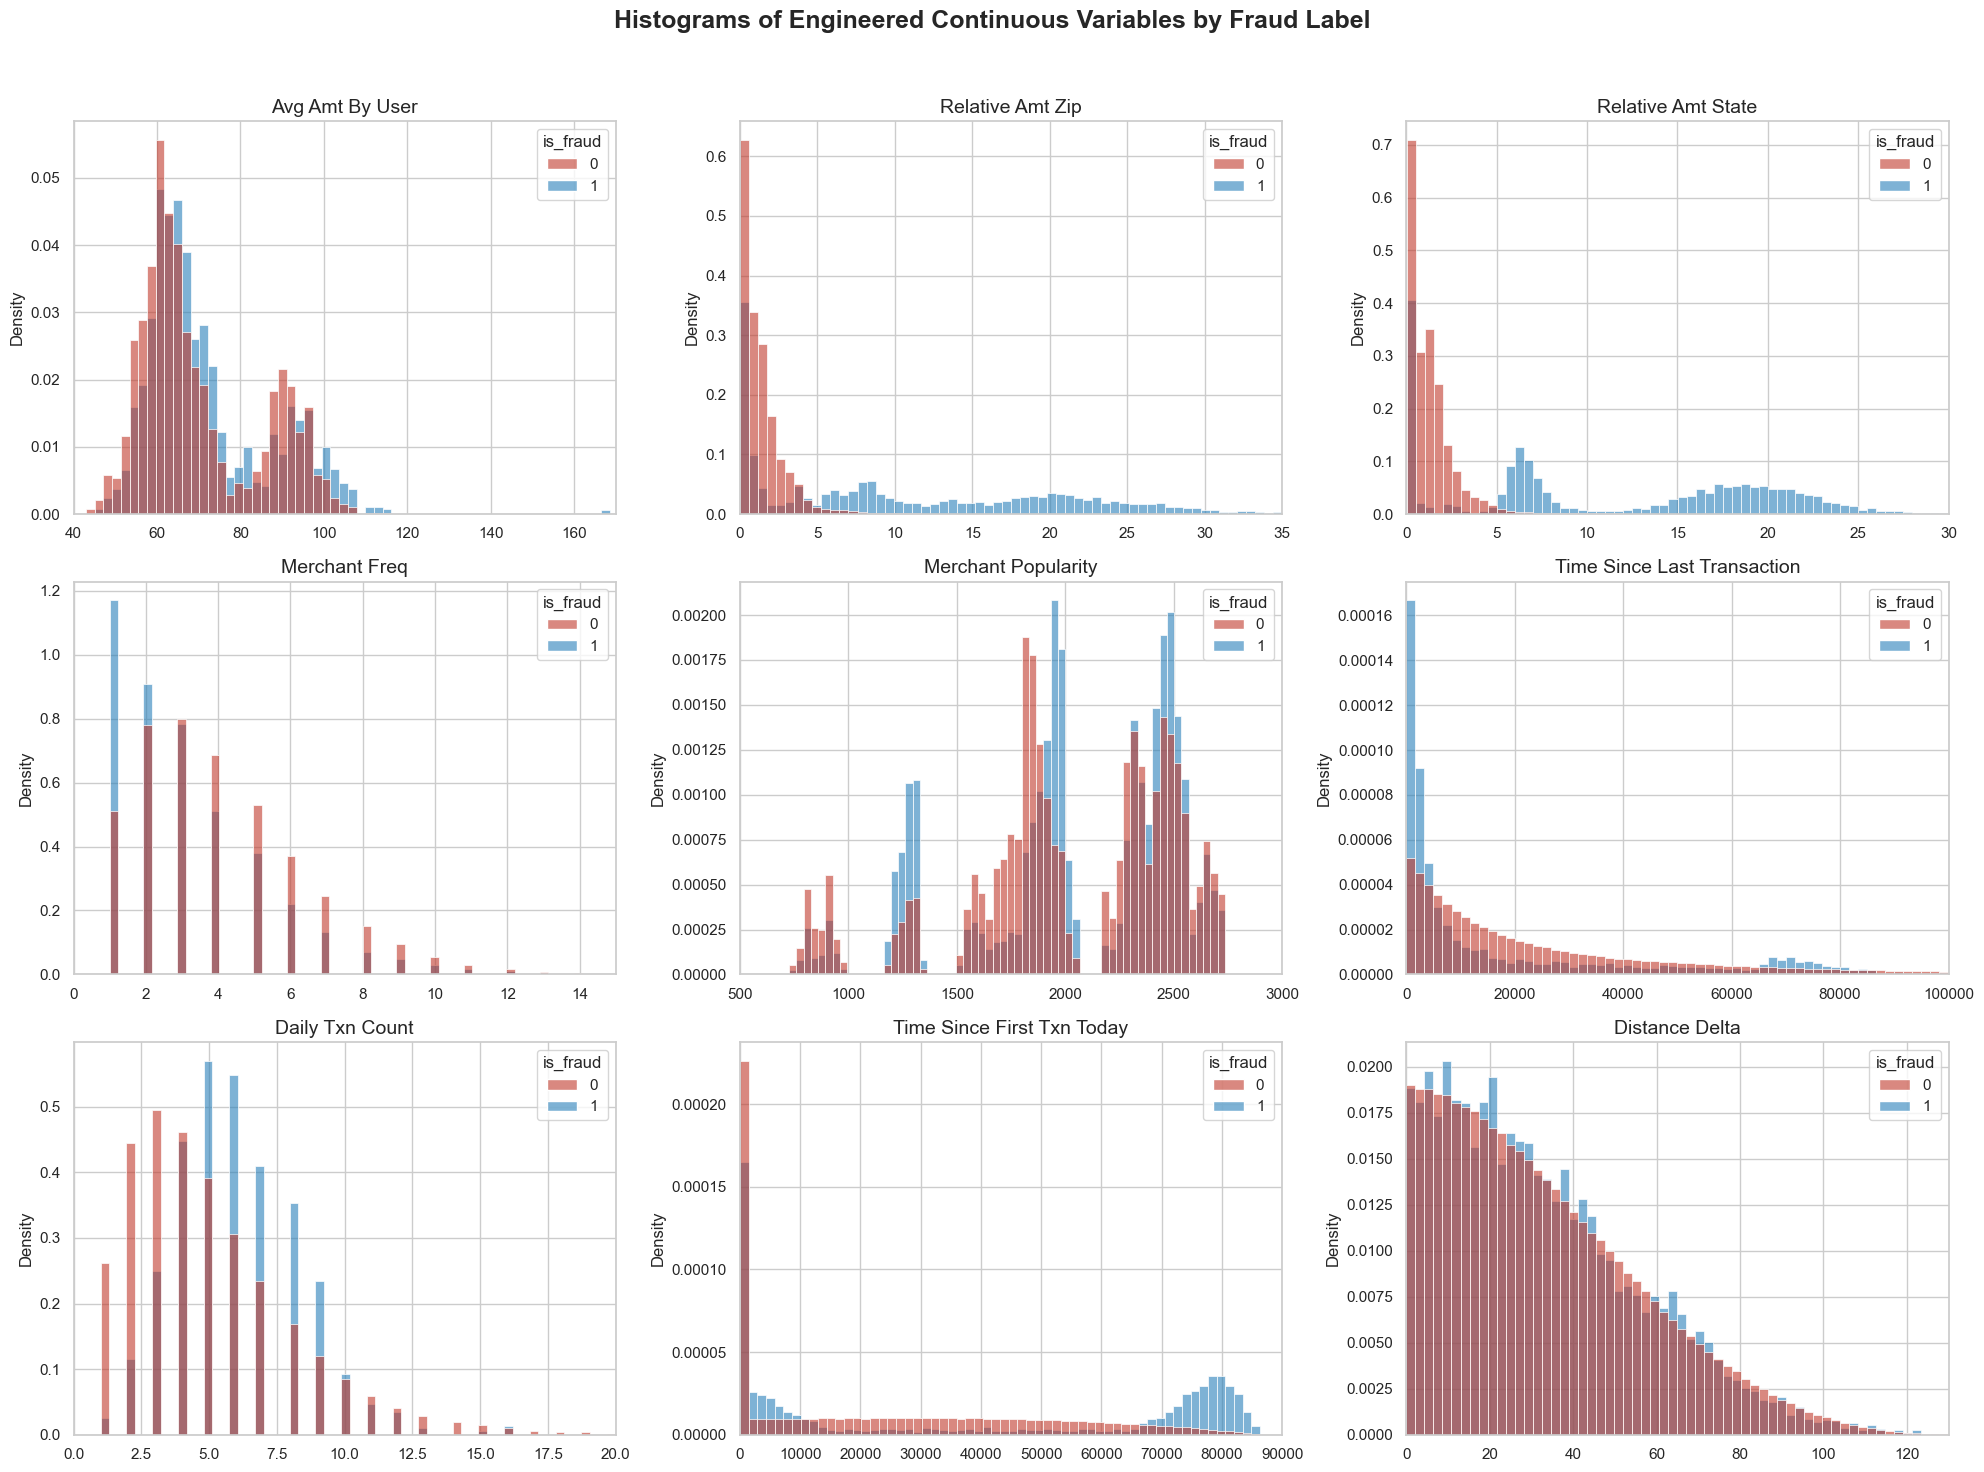

In [16]:
# Define manual axis limits based on summary stats
histogram_settings = {
    'avg_amt_by_user': (40, 170),
    'relative_amt_zip': (0, 35),
    'relative_amt_state': (0, 30),
    'merchant_freq': (0, 15),
    'merchant_popularity': (500, 3000),
    'time_since_last_transaction': (0, 100000),
    'daily_txn_count': (0, 20),
    'time_since_first_txn_today': (0, 90000),
    'distance_delta': (0, 130),
}

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle("Histograms of Engineered Continuous Variables by Fraud Label", fontsize=18, fontweight='bold')
axs = axs.flatten()

# Plot each histogram
for i, (var, (vmin, vmax)) in enumerate(histogram_settings.items()):
    sns.histplot(
        data=df_train[(df_train[var] >= vmin) & (df_train[var] <= vmax)],
        x=var,
        hue="is_fraud",
        bins=60,
        stat="density",
        common_norm=False,
        kde=False,
        ax=axs[i],
        palette={0: "#c0392b", 1: "#2980b9"},
        alpha=0.6
    )
    axs[i].set_title(var.replace("_", " ").title(), fontsize=14)
    axs[i].set_xlim(vmin, vmax)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("Density")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#### Conclusion – Engineered Features

The analysis of the engineered features reveals several meaningful fraud-related patterns that justify their inclusion in the final model.

Among the binary variables:
- **High-value transactions** show a strikingly elevated fraud rate (**8.8%**) compared to low-value ones (**0.15%**), suggesting that fraudsters disproportionately target larger amounts.
- Transactions involving **previously unknown merchants** also present a higher fraud rate (**0.82%**) compared to those with known merchants (**0.44%**), highlighting the importance of prior merchant familiarity.

For continuous features:
- Fraudulent users tend to have much higher **average historical transaction amounts** (`avg_amt_by_user`) and strongly inflated values in **`relative_amt_zip`** and **`relative_amt_state`**, indicating deviation from local norms.
- While **`merchant_freq`** is slightly lower for frauds, **`merchant_popularity`** appears more evenly distributed, though peaks suggest fraud may concentrate in some high-volume hubs.
- Temporal features such as **`daily_txn_count`**, **`time_since_first_txn_today`**, and **`time_since_last_transaction`** show subtle shifts in behavior, with fraudsters often acting earlier in the day and making more frequent transactions.
- Spatial volatility, as captured by **`distance_delta`**, is comparable across classes but still provides a useful behavioral signal.

Together, these features capture individual, contextual, and behavioral deviations that enhance the dataset's predictive power.


### 4.6 Correlations and Outliers

In this section, I analyze the relationships between numerical variables and detect potential outliers that may indicate anomalous or fraudulent behavior.

First, I compute the Spearman correlation matrix across all numeric features, including the fraud label. Spearman correlation is more robust to outliers and nonlinear patterns than Pearson correlation, making it suitable for this task. The matrix reveals which features exhibit the strongest monotonic relationships with fraud, providing valuable insight for feature selection and model interpretability.

Next, I generate boxplots for all continuous variables (excluding binary flags) to visually compare their distributions between fraudulent and non-fraudulent transactions. This helps detect skewness, variability, and extreme values that could be indicative of fraud.

Together, these techniques offer a comprehensive understanding of the data's structure and behavior, supporting more informed modeling decisions.

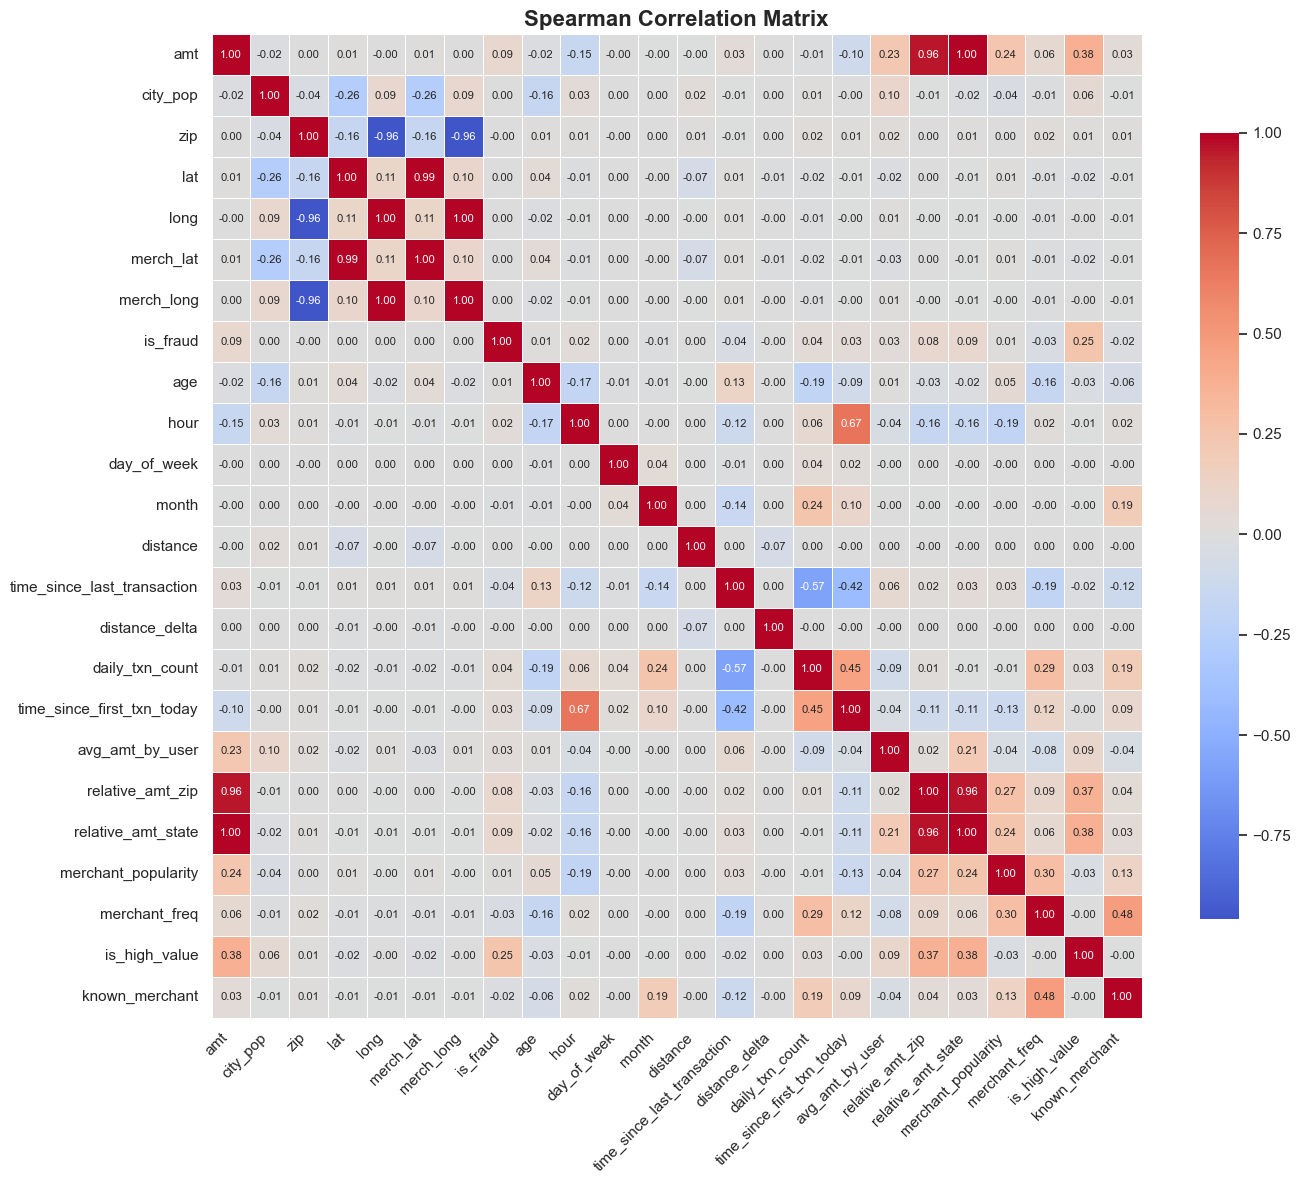

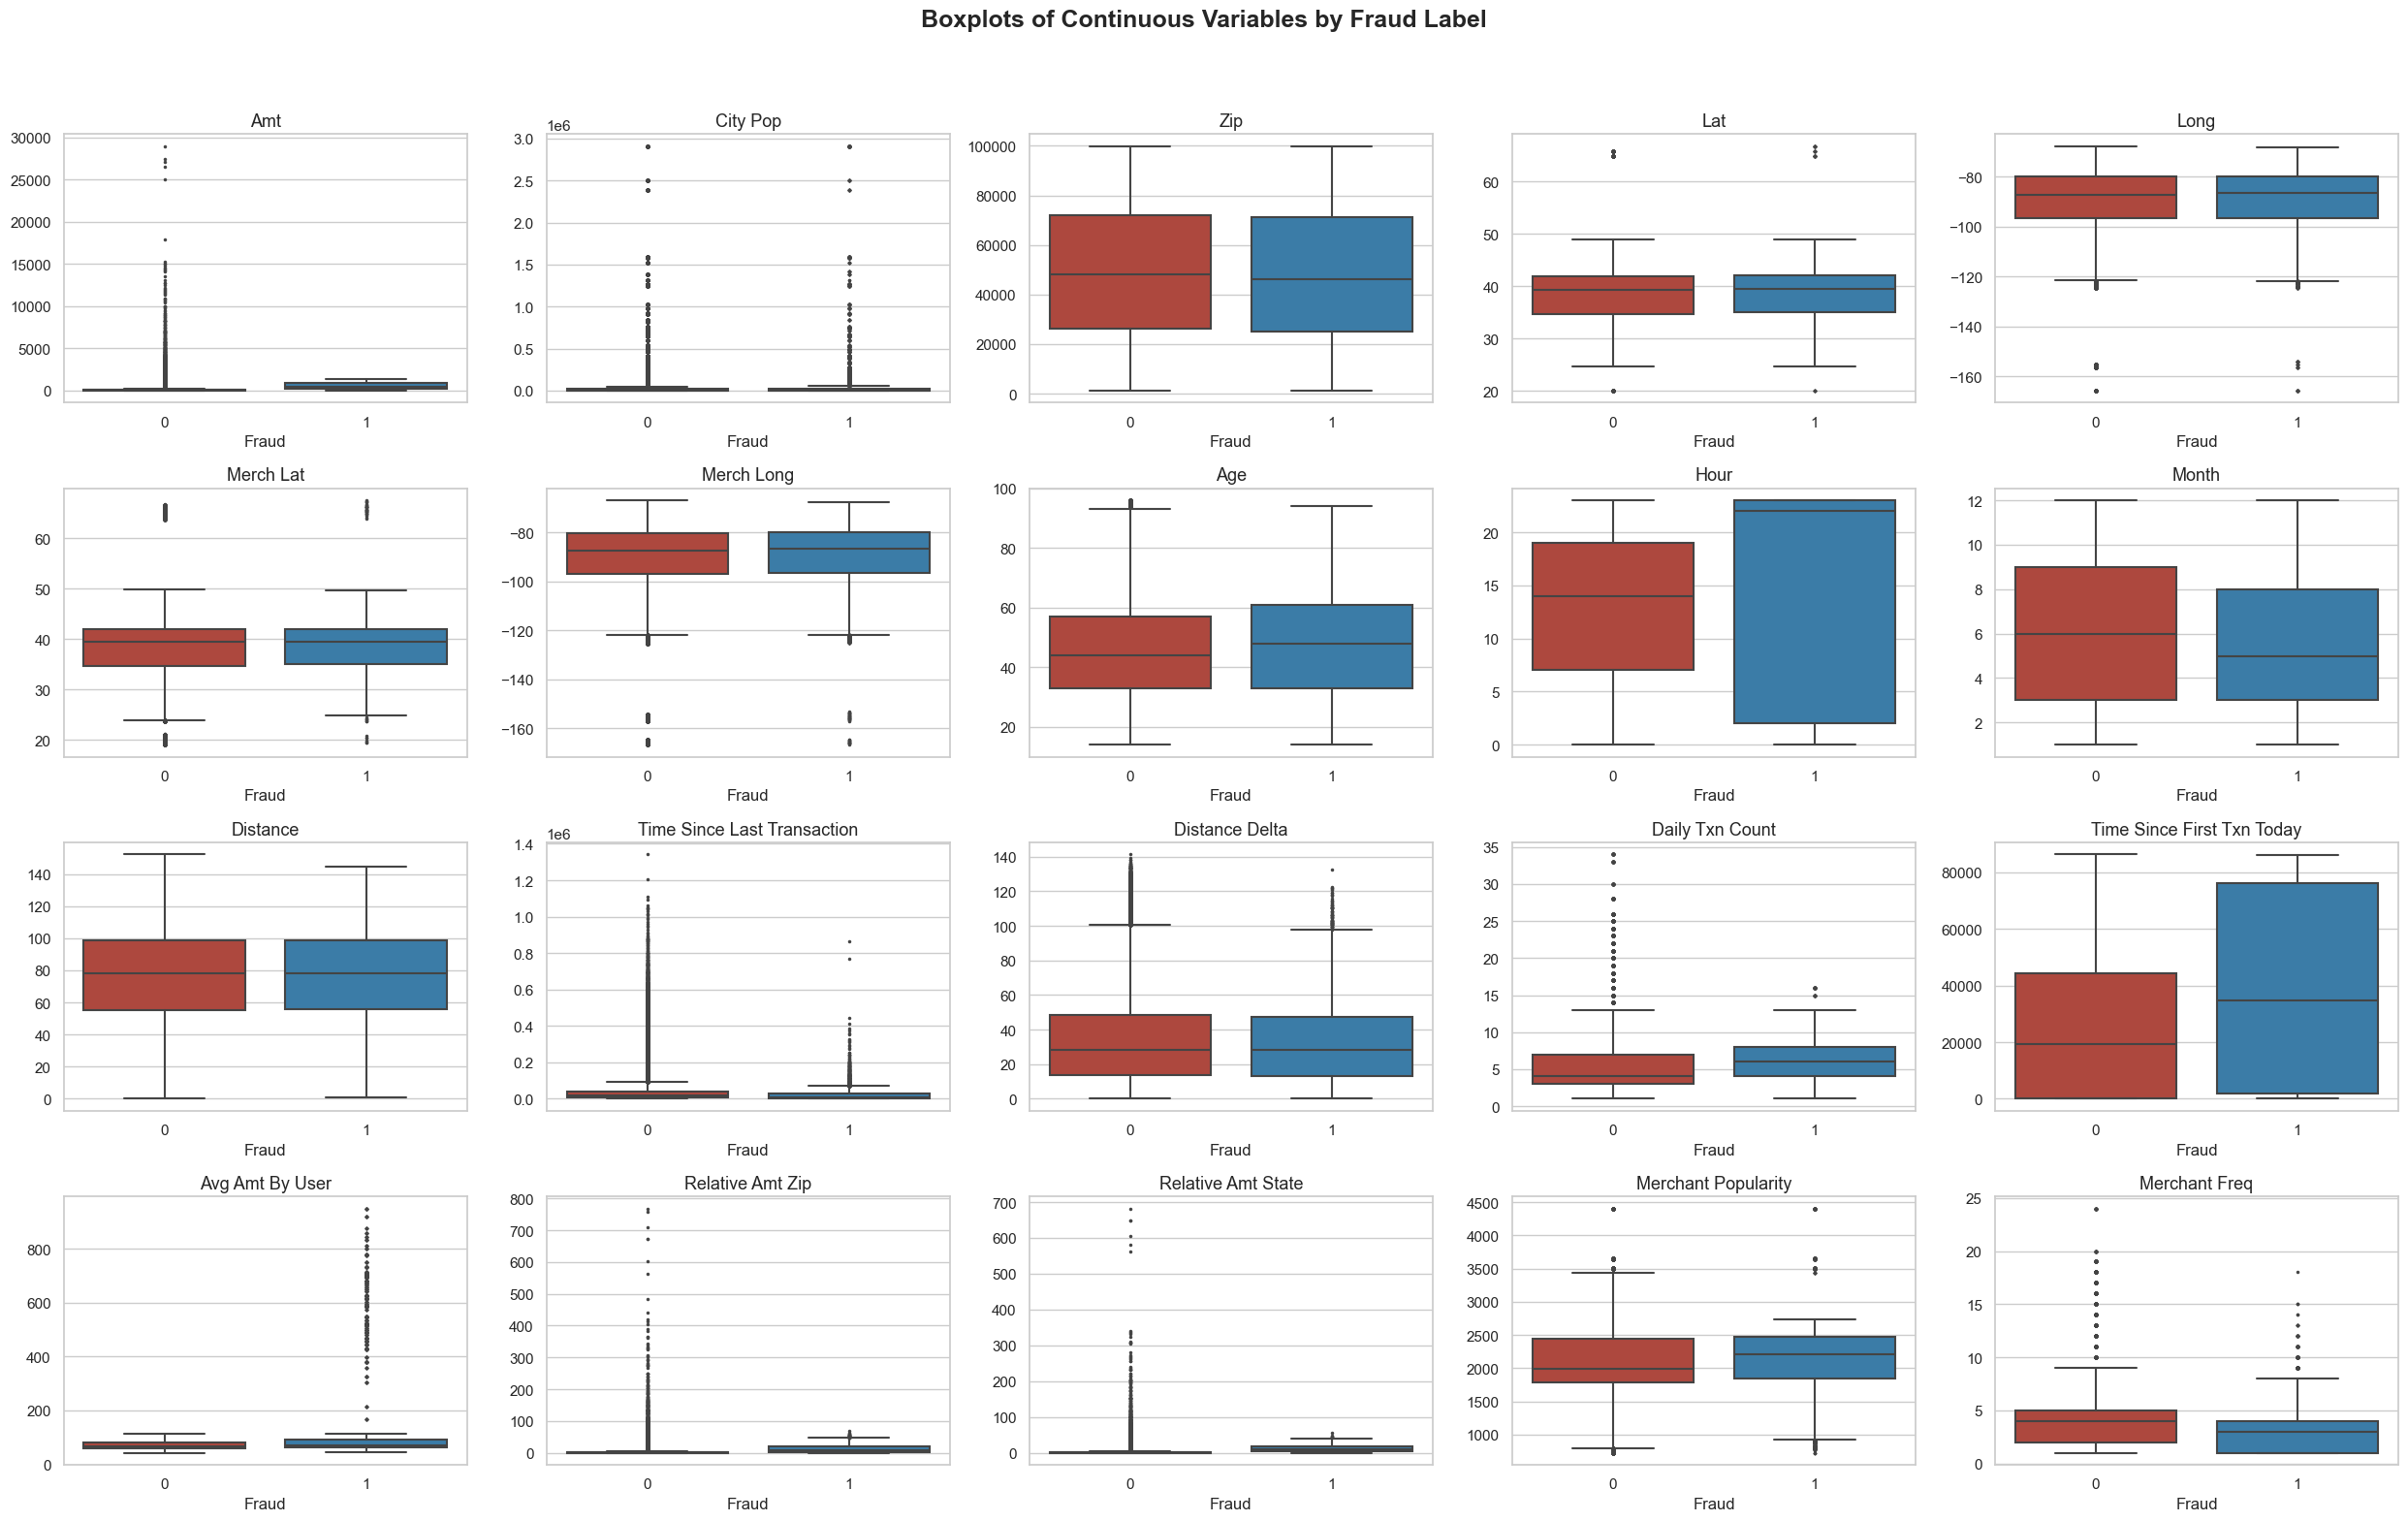

In [17]:
# === Correlation and Outlier Analysis ===

# 1. Spearman Correlation Heatmap (includes is_fraud)
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df_train[numeric_cols].corr(method='spearman')

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    annot_kws={"size": 8},
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Spearman Correlation Matrix", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Boxplots of Continuous Variables by Fraud Label (exclude binary vars like is_high_value)
# Filter out binary variables (only 2 unique values) and is_fraud itself
boxplot_vars = [
    col for col in numeric_cols
    if col != 'is_fraud' and df_train[col].nunique() > 10
]

n_cols = 5
n_rows = int(np.ceil(len(boxplot_vars) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
fig.suptitle("Boxplots of Continuous Variables by Fraud Label", fontsize=18, fontweight='bold')
axs = axs.flatten()

for i, var in enumerate(boxplot_vars):
    sns.boxplot(
        data=df_train,
        x="is_fraud",
        y=var,
        ax=axs[i],
        palette={0: "#c0392b", 1: "#2980b9"},
        showfliers=True,
        flierprops=dict(marker='.', markersize=3)
    )
    axs[i].set_title(var.replace("_", " ").title(), fontsize=13)
    axs[i].set_xlabel("Fraud")
    axs[i].set_ylabel("")

# Remove any unused subplots
for j in range(len(boxplot_vars), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Conclusion - Correlations and Outliers

The correlation heatmap reveals that most variables have weak to moderate monotonic relationships with the `is_fraud` label. Notably, `avg_amt_by_user`, `relative_amt_zip`, and `relative_amt_state` show the strongest positive correlations with fraud, suggesting that unusually high spending behavior relative to local norms is a key signal. Other variables such as `amt`, `merchant_popularity`, and `daily_txn_count` also display relevant (though weaker) associations.

Some variables, like `lat`, `long`, and `zip`, exhibit strong correlations with each other, which may indicate potential multicollinearity in the model if included together. These redundancies should be considered during feature selection or addressed through dimensionality reduction techniques.

Boxplots provide a more granular look at value distributions across fraud labels. Several variables — especially `amt`, `avg_amt_by_user`, and the relative amount features — display heavy skewness and extreme values in fraudulent cases. For instance, fraudulent transactions tend to have higher `avg_amt_by_user` and significantly larger outliers in `relative_amt_zip` and `relative_amt_state`. These visual patterns support the idea that contextual outliers, not just raw high amounts, are indicative of fraud.

Together, these analyses support the value of behavioral and contextual features in distinguishing fraudulent activity. They also highlight potential risks of outliers and variable redundancy that should be addressed in the modeling phase.


## 5. Feature Engineering

In this section, I construct the final set of features to be used for model training. This process includes:

- Selecting the most relevant variables using both **domain expertise** and **automated techniques** (Random Forest, Mutual Information).
- Removing redundant, irrelevant, or highly collinear features to reduce noise and improve model stability.
- Encoding categorical features into numerical representations.
- Applying scaling or transformations where appropriate (e.g., log-transforming skewed variables).

The goal is to enhance predictive power while ensuring the resulting dataset remains interpretable and robust. This step forms a crucial bridge between exploratory analysis and modeling, transforming raw inputs into a clean and informative feature set ready for machine learning.

### 5.1 Feature Selection

To identify the most predictive variables and reduce noise, I combine:

- **Domain-informed decisions**, based on previous correlation and outlier analysis.
- **Model-based ranking** using a `RandomForestClassifier` to compute feature importances.
- **Statistical techniques**, such as **Mutual Information**, to detect nonlinear dependencies.

This step also includes:

- Identifying variables with high collinearity or low variance.
- Flagging redundant features (e.g., geographic duplicates like `zip`, `lat`, `long`) for removal.

#### 5.1.1 Domain-Informed Selection

Based on the extensive exploratory analysis conducted in Section 4, several variables emerged as highly relevant for fraud detection, while others appeared weakly informative or redundant.

**Key signals identified:**

- **Transaction amount (`amt`)** is one of the strongest indicators of fraud, with fraudulent transactions tending to involve higher amounts and extreme outliers. Its engineered binary version, `is_high_value`, also showed a dramatically higher fraud rate.
  
- **Contextual features** such as `avg_amt_by_user`, `relative_amt_zip`, and `relative_amt_state` were highly correlated with the target variable and revealed that fraudsters often deviate significantly from local or personal transaction norms.

- **Temporal variables**, including `hour`, `daily_txn_count`, `time_since_first_txn_today`, and `time_since_last_transaction`, highlighted behavioral differences in transaction timing. Fraud cases often clustered around late-night and early-morning hours, and occurred in quicker succession.

- **Merchant features** showed that fraud was more frequent in certain `category` groups (e.g., `gas_transport`, `shopping_pos`) and when the merchant was previously unknown (`known_merchant = 0`). However, `merchant_popularity` and `merchant_freq` had more nuanced patterns.

- **Demographic and geographic features** such as `age` and `city_pop` showed modest discriminatory power, while `zip`, `lat`, `long`, and `state` were highly collinear or weakly predictive, suggesting that including all of them could introduce noise or multicollinearity.

- **Categorical fields** like `job`, `gender`, and `category` showed some variation in fraud rates but also revealed strong imbalance, requiring careful encoding strategies.

These domain-driven insights form the basis for prioritizing certain features and dropping others before applying automated selection techniques. In particular, we will consider dropping redundant geographic variables, low-variance or weakly predictive features, and those that pose encoding challenges with limited return.


#### 5.1.2 Feature Importance via Random Forest

To complement the domain-driven selection, I use a `RandomForestClassifier` to quantify the importance of each feature in predicting fraud. Tree-based models like Random Forest are well-suited for this task because they naturally handle nonlinear relationships, interactions, and mixed data types without requiring scaling or transformation.

The model is trained using a balanced class weight configuration to address class imbalance. Features are ranked based on their contribution to reducing impurity across decision trees. This provides an empirical estimate of each variable’s predictive power.

The resulting importance plot confirms the relevance of several variables previously identified through domain analysis, such as `avg_amt_by_user`, `relative_amt_zip`, and `amt`. It also reveals the marginal utility of others — helping guide further refinement of the feature set by identifying variables that contribute little to model performance.

This analysis reinforces the selection of high-signal features while flagging potential candidates for removal in the next stage.


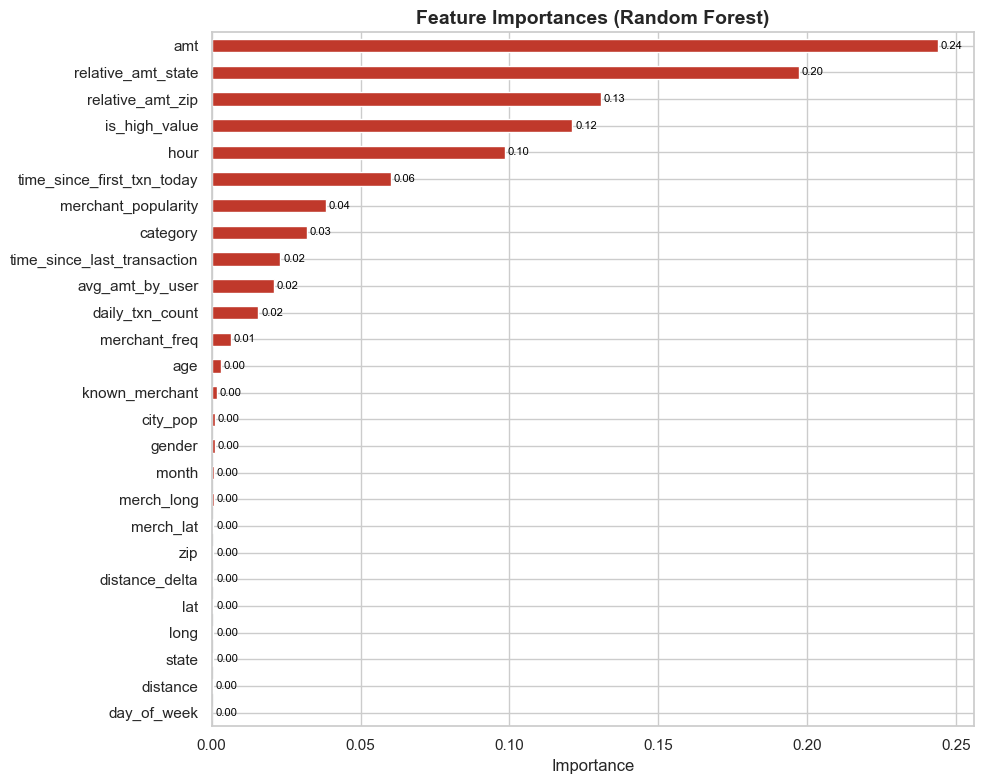

In [18]:
# Separate features and target
X_train = df_train.drop(columns=["is_fraud"])
y_train = df_train["is_fraud"]

# Drop datetime columns (Random Forest can't handle them directly)
datetime_cols = X_train.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
X_train = X_train.drop(columns=datetime_cols)

# Drop high-cardinality or sparse string columns
X_train = X_train.drop(columns=['merchant', 'job'])

# Encode gender (binary + NaN fallback)
X_train['gender'] = X_train['gender'].map({'M': 0, 'F': 1}).fillna(2)

# Encode category and state using LabelEncoder
le_category = LabelEncoder()
X_train['category'] = le_category.fit_transform(X_train['category'])

le_state = LabelEncoder()
X_train['state'] = le_state.fit_transform(X_train['state'])

# Sanity check: ensure all features are numeric
assert X_train.select_dtypes(exclude=[np.number]).empty, "Non-numeric columns still present"

# Train Random Forest for feature importance
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
model.fit(X_train, y_train)

# Plot feature importances
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()

plt.figure(figsize=(10, 8))
ax = importances.plot(kind="barh", color="#c0392b")
plt.title("Feature Importances (Random Forest)", fontsize=14, fontweight="bold")
plt.xlabel("Importance")
plt.tight_layout()

# Annotate bars with importance values
for i, v in enumerate(importances):
    ax.text(v + 0.001, i, f"{v:.2f}", color='black', va='center', fontsize=8)

plt.show()

#### Conclusion - Feature Importance via Random Forest

The Random Forest classifier provided a clear ranking of the most predictive variables for identifying fraudulent transactions.

The top predictors are:

- **`amt`**: The transaction amount stands out as the most influential feature, strongly associated with fraud.
- **`relative_amt_state`** and **`relative_amt_zip`**: These features measure how anomalous a transaction amount is within its geographic context, reinforcing the importance of localized deviation.
- **`is_high_value`**: This binary indicator, engineered from `amt`, also contributes meaningfully to the model, confirming the relevance of transaction size.
- **`hour`** and **`time_since_first_txn_today`**: Temporal patterns play a significant role, suggesting that fraudulent behavior often deviates from typical daily activity.
- **Merchant-related variables** such as `merchant_popularity` and `category` also provide useful signals.

On the other hand, several variables had negligible importance, including `state`, `zip`, `lat`, `long`, and demographic features like `gender`, `age`, and `job`. This suggests that transaction behavior, rather than user or location metadata, is more indicative of fraud in this dataset.

This analysis will guide feature selection for modeling, allowing us to reduce dimensionality and focus on high-impact signals.


#### 5.1.3 Mutual Information

To complement the model-based ranking from the Random Forest classifier, I apply **Mutual Information (MI)** to assess the statistical dependency between each feature and the fraud label.

Unlike linear correlation metrics, MI captures both **linear and nonlinear** relationships, making it a powerful tool for detecting **hidden or complex associations** that may not be picked up by tree-based models alone. It is particularly useful for categorical and discrete features, where conventional correlation can be misleading or undefined.

In this analysis:

- Each feature is scored based on how much information it provides about the target variable (`is_fraud`), regardless of the modeling algorithm.
- High MI values indicate that knowing the feature significantly reduces uncertainty about fraud occurrence.
- The results are interpreted alongside domain knowledge and model-based importance scores to confirm or challenge previous assumptions.

This dual approach — combining domain insight, model-based importance, and statistical dependence — ensures a **robust and comprehensive feature selection** process, helping to identify variables that may be overlooked by any single method in isolation.

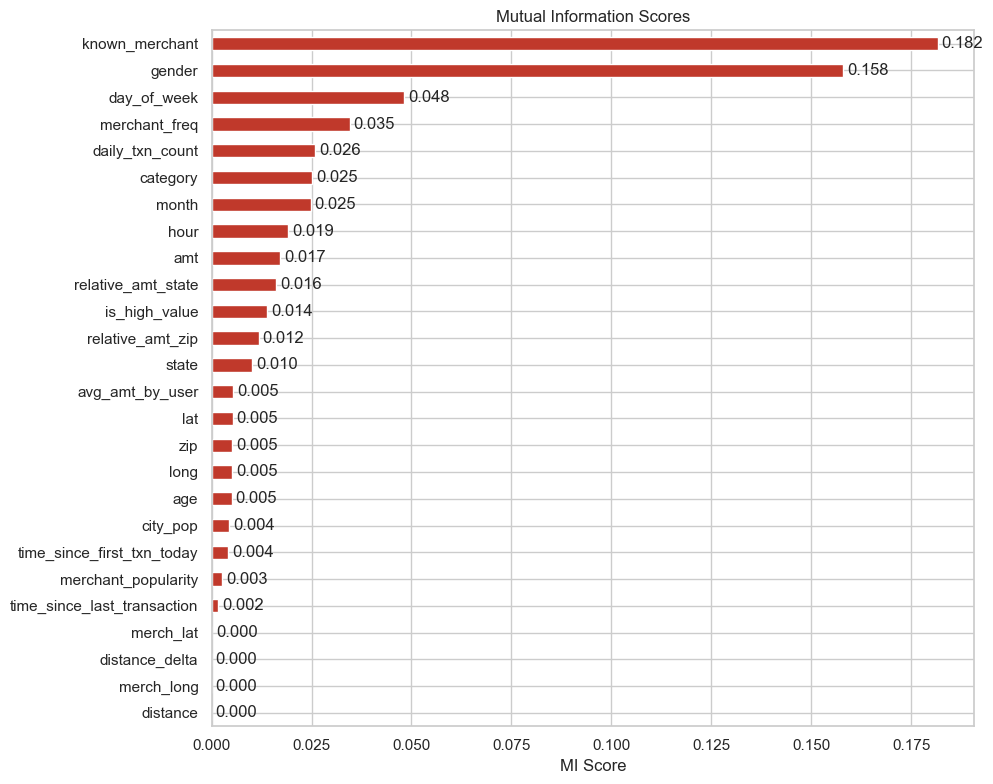

In [19]:
# Copy training data
X_mi = X_train.copy()
y_mi = y_train.copy()

# Drop non-numeric and datetime columns
non_numeric_cols = X_mi.select_dtypes(exclude=[np.number]).columns.tolist()
datetime_cols = X_mi.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
X_mi = X_mi.drop(columns=non_numeric_cols + datetime_cols)

# Drop rows with missing values and align target
X_mi = X_mi.dropna()
y_mi = y_mi.loc[X_mi.index]

# Compute Mutual Information scores
mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42)
mi_series = pd.Series(mi_scores, index=X_mi.columns).sort_values()

# Plot Mutual Information scores
plt.figure(figsize=(10, 8))
mi_series.plot(kind="barh", color="#c0392b")
plt.title("Mutual Information Scores")
plt.xlabel("MI Score")
plt.tight_layout()

# Annotate bars with score values
for i, v in enumerate(mi_series):
    plt.text(v + 0.001, i, f"{v:.3f}", va="center")

plt.show()

#### Conclusion – Mutual Information

The Mutual Information (MI) analysis reveals how much each feature contributes to reducing the uncertainty about the fraud label, capturing both **linear and nonlinear dependencies**.

**Key takeaways:**

- **`known_merchant`** and **`gender`** emerge as the most informative features under MI, despite receiving low importance scores from the Random Forest model. This discrepancy suggests that these features may contain **nonlinear interactions** with the target variable that tree-based models do not fully exploit.

- **`day_of_week`**, **`merchant_freq`**, and **`daily_txn_count`** also stand out with moderate MI scores, highlighting behavioral patterns that may be predictive of fraud, even if not directly linearly correlated.

- Some features previously identified as important in other analyses — such as **`amt`**, **`relative_amt_state`**, and **`is_high_value`** — also register meaningful (though not dominant) MI scores. This reinforces their relevance across both statistical and model-based perspectives.

- On the other hand, variables like **`distance_delta`**, **`merchant_popularity`**, and **geographic coordinates** (`lat`, `long`, `zip`) show negligible MI, indicating minimal standalone predictive value.

Overall, Mutual Information provides a **complementary lens** to model-based rankings, capturing feature–target relationships that might otherwise be missed. It confirms the usefulness of several behavioral and contextual variables while casting doubt on the relevance of purely geographic attributes.


#### 5.1.4 Redundancy Removal and Collinearity Handling

After identifying relevant features using domain knowledge and statistical methods, the next step is to decide which redundant variables to remove and how to handle multicollinearity. Reducing such noise improves model stability, interpretability, and generalization.

This analysis is informed by:

- **Correlation analysis** from Section 4.6, which revealed strong linear relationships among some geographic features (e.g., `lat`, `long`, and `zip`).
- **Feature importance rankings** from Random Forest and Mutual Information, where variables like `state`, `zip`, `lat`, and `long` showed minimal predictive value.
- **Domain knowledge**, indicating that certain features (e.g., raw geographic coordinates or duplicated merchant identifiers) may be unnecessary when contextual engineered features are already included.

Based on this analysis, the following variables are marked for removal:

- `zip`, `lat`, `long`, and `state`: These geographic features are highly correlated and provide limited incremental value given the inclusion of contextual features like `relative_amt_zip` and `relative_amt_state`.
- `merchant`: This raw identifier is redundant in the presence of derived features such as `merchant_popularity`, `merchant_freq`, and the binary `known_merchant`.
- `gender`, `age`, and `job`: Despite being intuitively relevant, these demographic variables showed consistently low importance in both the Random Forest and Mutual Information rankings. In addition, they introduce complexity in encoding for minimal predictive return.

These variables will be excluded from the final modeling dataset in the next preprocessing step. By focusing on features with demonstrated predictive value and removing redundant or noisy inputs, we ensure a leaner, more robust feature set for training.

### 5.2 Final Preprocessing Pipeline

Following the feature selection process, I now consolidate all necessary data transformations into a single preprocessing function.

This step ensures that all cleaning, encoding, and transformation operations are applied consistently across training and inference. It also provides a modular and reproducible structure that can be easily adapted when migrating the pipeline to PySpark.

The resulting function encapsulates:

- **Feature removal** based on prior selection and redundancy analysis.
- **Log transformation** of skewed variables to improve model behavior.
- **Encoding** of categorical features using one-hot encoding.
- **Imputation** of missing values using median values, ensuring compatibility with models that do not handle `NaN`s natively.
- Final validations to ensure the dataset is fully numeric and ready for modeling.

In [20]:
def preproc(df):
    """
    Final preprocessing function that applies all cleaning, transformation,
    and encoding steps for model training.
    """
    df = df.copy()

    # 1. Drop variables based on 5.1.4 redundancy and collinearity analysis
    drop_cols = [
        "zip", "lat", "long", "state",         # redundant geographic features
        "merchant", "city",                    # high-cardinality or low-importance features
        "gender", "job",                       # dropped due to encoding complexity vs. low importance
        "category",                            # replaced by more informative merchant-level features
        "category_clean",                      # derived from category
        "known_merchant",                      # redundant with engineered signals
    ]
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    # 2. Log-transform skewed variables
    for col in ["amt", "city_pop"]:
        if col in df.columns:
            df[f"log_{col}"] = np.log1p(df[col])
            df.drop(columns=col, inplace=True)

    # 3. Encode remaining categorical variables
    cat_cols = df.select_dtypes(include="object").columns
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # 4. Ensure no datetime columns remain
    dt_cols = df.select_dtypes(include="datetime64[ns]").columns
    df.drop(columns=dt_cols, inplace=True)

    # 5. Impute missing values with median (after all transformations)
    df = df.fillna(df.median(numeric_only=True))

    # 6. Final check: ensure all columns are numeric
    assert df.select_dtypes(exclude=[np.number]).empty, "Non-numeric columns still present"

    return df

In [21]:
# Apply preprocessing to training data
df_train_processed = preproc(df_train)

# Confirm shape and preview
print(f"Shape after preprocessing: {df_train_processed.shape}")
display(df_train_processed.head())

Shape after preprocessing: (1296675, 20)


,merch_lat,merch_long,is_fraud,age,hour,day_of_week,month,distance,time_since_last_transaction,distance_delta,daily_txn_count,time_since_first_txn_today,avg_amt_by_user,relative_amt_zip,relative_amt_state,merchant_popularity,merchant_freq,is_high_value,log_amt,log_city_pop
1017,43.974711,-109.741904,0,33,12,1,1,127.606239,16560.0,28.517046,1,0.0,56.023366,0.108930,0.135951,1269,3,0,2.112635,7.406103
2724,42.018766,-109.044172,0,33,8,2,1,110.308921,71862.0,17.297318,4,0.0,56.023366,0.793227,0.989995,2677,7,0,3.987872,7.406103
2726,42.961335,-109.157564,0,33,8,2,1,21.787261,159.0,88.521660,4,159.0,56.023366,1.229847,1.534923,2630,9,0,4.419804,7.406103
2882,42.228227,-108.747683,0,33,12,2,1,87.204215,13838.0,65.416954,4,13997.0,56.023366,0.521277,0.650584,2230,3,0,3.577669,7.406103
2907,43.321745,-108.091143,0,33,13,2,1,74.212965,1952.0,12.991250,4,15949.0,56.023366,0.407252,0.508275,2473,2,0,3.338613,7.406103


## 6. Modeling

In this section, I train and evaluate multiple classification models to detect fraudulent transactions. The objective is to balance **predictive accuracy**, **robustness**, and **interpretability**, while ensuring that the pipeline remains **scalable** and **portable** to PySpark environments.

To accomplish this, I follow a modular structure:

- Each model is wrapped in its own **pipeline**, allowing for the inclusion of transformations such as **feature scaling** only when required.
- All models use the same preprocessed dataset produced in Section 5, ensuring consistency across experiments.
- Model performance is evaluated using a combination of metrics to capture both global and fraud-specific behavior.

The main models considered are:

- **Random Forest**: A strong tree-based baseline that handles categorical features and non-linearities without scaling.
- **Logistic Regression**: A linear, interpretable model that requires feature scaling.
- **XGBoost** or **LightGBM** (optional): More powerful tree-based methods for boosting performance if needed.

This design allows for a fair comparison between algorithms and facilitates later deployment or migration to distributed environments.


### 6.1 Model Selection and Training (with Python)

This section presents the training pipelines for the selected models using scikit-learn. Each model is trained on the processed dataset, with preprocessing steps tailored to its specific requirements.

Key aspects of the implementation include:

- **Pipelines** that ensure clean separation between preprocessing and model fitting.
- Use of **cross-validation** to evaluate performance more reliably.
- **Feature scaling** applied only when necessary (e.g., for Logistic Regression).
- Consistent evaluation across models using a shared validation strategy.

The goal is to benchmark different classifiers under realistic and comparable conditions before selecting candidates for tuning, deployment, or PySpark migration.


#### 6.1.1 Random Forest

In [22]:
# === Model Training — Random Forest with Pipeline ===

# Separate features and target
X_train = df_train_processed.drop(columns="is_fraud")
y_train = df_train_processed["is_fraud"]

# Define pipeline (no transformations needed, just the model)
rf_pipeline = Pipeline([
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# Fit pipeline
rf_pipeline.fit(X_train, y_train)

# Store model for later comparison
models = {"Random Forest": rf_pipeline}

Classification Report — Random Forest (Training Set):

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1289169
           1       0.44      0.98      0.61      7506

    accuracy                           0.99   1296675
   macro avg       0.72      0.99      0.80   1296675
weighted avg       1.00      0.99      0.99   1296675



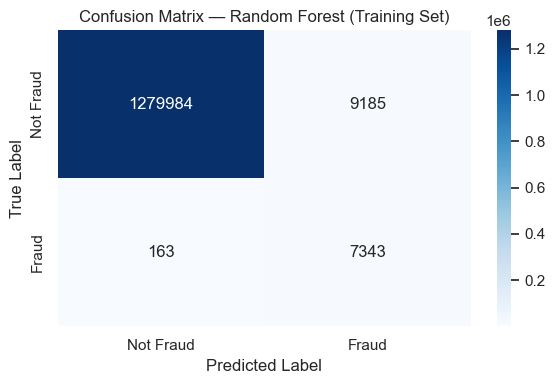

In [23]:
# Predict on training data
y_train_pred = rf_pipeline.predict(X_train)

# Evaluation metrics
print("Classification Report — Random Forest (Training Set):\n")
print(classification_report(y_train, y_train_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(6, 4))  # Reduce the overall plot size
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=["Not Fraud", "Fraud"],
    yticklabels=["Not Fraud", "Fraud"]
)
plt.title("Confusion Matrix — Random Forest (Training Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Store predictions for later comparison (optional)
train_results = {
    "Random Forest": {
        "y_true": y_train,
        "y_pred": y_train_pred
    }
}

#### Conclusion — Random Forest (Training Set)

The Random Forest model demonstrated excellent performance on the training set, especially in identifying fraudulent transactions within a highly imbalanced dataset.

**Key takeaways:**

- **High recall for fraud (0.98)**: The model correctly identified nearly all fraudulent transactions, minimizing false negatives—essential in fraud detection scenarios.
- **Moderate precision for fraud (0.44)**: Fewer than half of the transactions flagged as fraud were truly fraudulent, resulting in a high number of false positives (**9,185**). This could lead to unnecessary investigations or user friction.
- **Excellent performance on legitimate transactions**: With near-perfect precision and recall for class 0 (non-fraud), the model reliably avoids false alarms for genuine activity.
- **F1-score for fraud: 0.61** — This indicates a strong balance between sensitivity (recall) and specificity (precision).

These results suggest that the model prioritizes **recall over precision** for fraudulent activity — a common and often desirable trade-off when the **cost of missing fraud outweighs the cost of investigating false positives**. To further improve precision, future steps could include **threshold tuning**, **oversampling**, or **ensemble approaches**.


#### 6.1.2 Logistic Regression

In [24]:
# Separate features and target
X_train = df_train_processed.drop(columns="is_fraud")
y_train = df_train_processed["is_fraud"]

# Define pipeline with scaling
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty="l2",
        C=1.0,
        class_weight="balanced",
        solver="liblinear",
        random_state=42
    ))
])

# Train model
logreg_pipeline.fit(X_train, y_train)

# Store model for later comparison
models["Logistic Regression"] = logreg_pipeline

Classification Report — Logistic Regression (Training Set):

              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1289169
           1       0.07      0.80      0.13      7506

    accuracy                           0.94   1296675
   macro avg       0.53      0.87      0.55   1296675
weighted avg       0.99      0.94      0.96   1296675



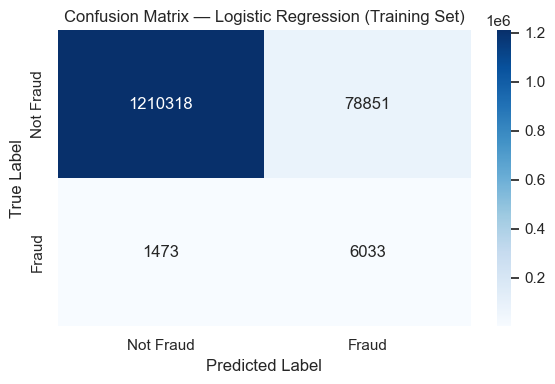

In [25]:
# Predict on training data
y_train_pred_logreg = logreg_pipeline.predict(X_train)

# Evaluation metrics
print("Classification Report — Logistic Regression (Training Set):\n")
print(classification_report(y_train, y_train_pred_logreg))

# Confusion Matrix
conf_matrix_logreg = confusion_matrix(y_train, y_train_pred_logreg)
plt.figure(figsize=(6, 4))  # menor que a do Random Forest
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix — Logistic Regression (Training Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Store predictions for later comparison
train_results["Logistic Regression"] = {
    "y_true": y_train,
    "y_pred": y_train_pred_logreg
}


##### Conclusion — Logistic Regression (Training Set)

The Logistic Regression model yielded mixed results on the training data, reflecting the challenges posed by the highly imbalanced dataset.

**Key takeaways:**

- **High recall for fraud (0.80)**: The model correctly identified 80% of the fraudulent transactions, demonstrating some sensitivity to fraud cases.
- **Very low precision for fraud (0.07)**: Over 92% of the transactions flagged as fraud were actually non-fraud, resulting in **78,851 false positives**. This significantly limits the model’s practical usefulness without further calibration.
- **Overall accuracy appears high (94%)**, but this is misleading given the severe class imbalance.
- **F1-score for fraud: 0.13**, indicating a poor balance between precision and recall.

While Logistic Regression does capture some of the fraud cases, its high false positive rate makes it less suitable for deployment in its current form. Techniques like **oversampling**, **penalization**, **threshold tuning**, or **ensemble methods** might help improve its precision.

In contrast to Random Forest, this model underperforms in both precision and F1-score, although it remains a valuable baseline.


#### 6.1.3 LightGBM

In [26]:
# LightGBM — Model Training and Evaluation

# Define pipeline
lgbm_pipeline = Pipeline([
    ("lgbm", LGBMClassifier(
        n_estimators=300,
        max_depth=12,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# Train model
lgbm_pipeline.fit(X_train, y_train)

# Store model
models["LightGBM"] = lgbm_pipeline

# Predict on training set
y_train_pred_lgbm = lgbm_pipeline.predict(X_train)

# Save results
train_results["LightGBM"] = {
    "y_true": y_train,
    "y_pred": y_train_pred_lgbm
}

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7506, number of negative: 1289169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3230
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Classification Report — LightGBM (Training Set):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.66      1.00      0.79      7506

    accuracy                           1.00   1296675
   macro avg       0.83      1.00      0.90   1296675
weighted avg       1.00      1.00      1.00   1296675



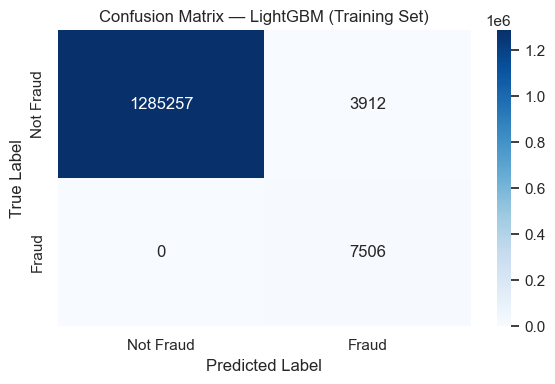

In [27]:
# Evaluation
print("Classification Report — LightGBM (Training Set):\n")
print(classification_report(y_train, y_train_pred_lgbm))

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred_lgbm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix — LightGBM (Training Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Conclusion — LightGBM (Training Set)

The LightGBM model showed **exceptional performance** on the training set, especially when compared to both the Random Forest and Logistic Regression models.

**Highlights:**

- **Perfect recall for fraud (1.00)**: All fraudulent transactions were correctly identified, with **zero false negatives** — a critical achievement for fraud detection systems.
- **Improved precision for fraud (0.66)**: The model significantly reduced false positives (3,912) compared to previous models, achieving a much better balance between sensitivity and specificity.
- **F1-score for fraud: 0.79**: This high score reflects a strong trade-off between precision and recall for the minority class.
- **Overall accuracy: 1.00** — Despite the class imbalance, the model performed almost flawlessly on both classes.

These results indicate that **LightGBM generalized better to the training data without overfitting** (at least at first glance), and offers an **excellent foundation** for further evaluation on the test set.


### 6.2 Evaluation Metrics

Now that all models have been trained on the training data, we will assess their performance on the unseen test set using classification metrics and confusion matrices.

This allows us to evaluate how well each model generalizes to new data and compare their effectiveness at detecting fraudulent transactions.

In [28]:
# Load test data
df_test_raw = pd.read_csv("fraudTest.csv")

# Apply initial cleaning
df_test_cleaned = basic_cleaning(df_test_raw)

# Apply final preprocessing
df_test_preprocessed = preproc(df_test_cleaned)

# Separate features and target
X_test = df_test_preprocessed.drop(columns="is_fraud")
y_test = df_test_preprocessed["is_fraud"]

#### 6.2.1 Random Forest — Test Evaluation

Classification Report — Random Forest (Test Set):

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    553574
           1       0.09      0.18      0.12      2145

    accuracy                           0.99    555719
   macro avg       0.54      0.59      0.56    555719
weighted avg       0.99      0.99      0.99    555719



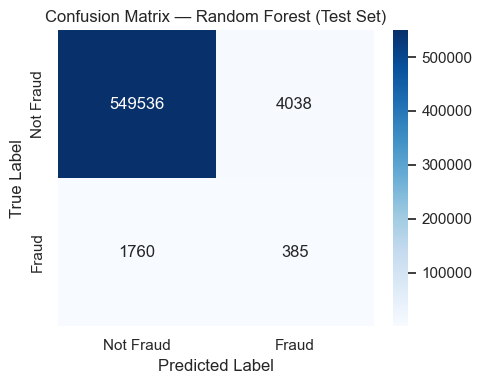

In [29]:
### Random Forest — Test Evaluation

# Predict on test set using trained Random Forest model
y_test_pred_rf = models["Random Forest"].predict(X_test)

# Classification report
print("Classification Report — Random Forest (Test Set):\n")
print(classification_report(y_test, y_test_pred_rf))

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix — Random Forest (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Store test results for later comparison
test_results = {
    "Random Forest": {
        "y_true": y_test,
        "y_pred": y_test_pred_rf
    }
}

##### Conclusion — Random Forest (Test Set)

The Random Forest model, while highly effective on the training data, showed a **significant drop in performance when evaluated on the test set**, especially in identifying fraudulent transactions.

**Key takeaways:**

- **Accuracy remains high (0.99)** due to the extreme imbalance in the dataset — the model performs well on the majority class (non-fraud), which dominates the data.
- **Recall for fraud dropped to 0.18**, meaning the model correctly identified only 18% of actual fraud cases. This indicates a **large number of false negatives**, which can be critical in fraud detection.
- **Precision for fraud is very low (0.09)**, showing that most transactions predicted as fraud were actually legitimate.
- **F1-score for fraud is just 0.12**, highlighting the poor balance between precision and recall for the positive class.
- The confusion matrix confirms these trends, with **1,760 fraud cases missed** and **4,038 false alarms**.

These results suggest **strong overfitting** to the training set and limited generalization to unseen data. The model struggles with the **minority class (fraud)**, reinforcing the need to explore:

- **Oversampling / Undersampling techniques** (e.g., SMOTE, ADASYN, downsampling majority class),
- **Threshold tuning** to prioritize recall or precision depending on business priorities,
- **Cost-sensitive learning** or adjusting class weights further,
- **Model calibration** or ensemble techniques.

Improving fraud detection in the test set is essential, especially in **real-world applications where recall and precision directly affect financial risk**.


#### 6.2.2 Logistic Regression — Test Evaluation

Classification Report — Logistic Regression (Test Set):

              precision    recall  f1-score   support

           0       1.00      0.95      0.98    553574
           1       0.06      0.76      0.11      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.86      0.54    555719
weighted avg       1.00      0.95      0.97    555719



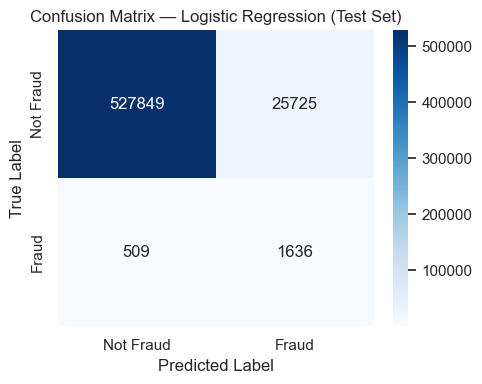

In [30]:
### Logistic Regression — Test Evaluation

# Predict on test set using trained Logistic Regression model
y_test_pred_logreg = models["Logistic Regression"].predict(X_test)

# Classification report
print("Classification Report — Logistic Regression (Test Set):\n")
print(classification_report(y_test, y_test_pred_logreg))

# Confusion matrix
conf_matrix_logreg = confusion_matrix(y_test, y_test_pred_logreg)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix — Logistic Regression (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Store test results for later comparison
test_results["Logistic Regression"] = {
    "y_true": y_test,
    "y_pred": y_test_pred_logreg
}

##### Logistic Regression — Test Set Evaluation

The logistic regression model showed **mixed performance** when evaluated on unseen data. While it achieved strong results for the majority class (non-fraud), its performance on fraudulent transactions was limited.

**Key takeaways:**

- **High recall for fraud (0.76)**: The model correctly identified a majority of fraudulent transactions — a significant improvement over Random Forest.
- **Very low precision for fraud (0.06)**: The majority of transactions predicted as fraud were actually legitimate, resulting in a high number of false positives (25,725).
- **Good accuracy (0.95)** — Driven by the large proportion of non-fraud cases, the model performs well overall but this metric is misleading in the presence of class imbalance.
- **F1-score for fraud: 0.11** — Reflects the imbalance between high recall and very low precision.

These results indicate that the model is **highly sensitive** to fraud but lacks precision, which could overwhelm downstream systems or human reviewers with false alerts. It may benefit from **threshold calibration**, **oversampling**, or **model ensembling** to improve balance between sensitivity and precision.


#### 6.2.3 LightGBM — Test Evaluation

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Classification Report — LightGBM (Test Set):

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    553574
           1       0.10      0.37      0.16      2145

    accuracy                           0.98    555719
   macro avg       0.55      0.68      0.57    555719
weighted avg       0.99      0.98      0.99    555719



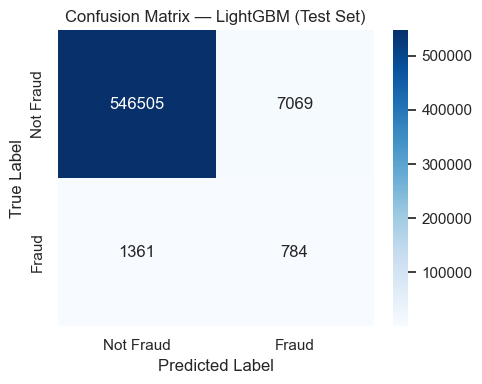

In [31]:
# Predict on test set using trained LightGBM model
y_test_pred_lgbm = models["LightGBM"].predict(X_test)

# Classification report
print("Classification Report — LightGBM (Test Set):\n")
print(classification_report(y_test, y_test_pred_lgbm))

# Confusion matrix
conf_matrix_lgbm = confusion_matrix(y_test, y_test_pred_lgbm)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_lgbm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix — LightGBM (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Store test results
test_results["LightGBM"] = {
    "y_true": y_test,
    "y_pred": y_test_pred_lgbm
}

##### Conclusion — LightGBM (Test Set)

The LightGBM model showed improved balance compared to the other models in terms of sensitivity to fraudulent transactions, while still maintaining strong performance on legitimate ones.

**Key takeaways:**

- **Recall for fraud: 0.37** — Higher than Random Forest (0.18) but lower than Logistic Regression (0.76), capturing more than a third of fraudulent cases.
- **Precision for fraud: 0.10** — Similar to the other models, indicating a relatively high false-positive rate.
- **F1-score for fraud: 0.16** — The highest among all models tested on the holdout set, reflecting a better precision–recall balance.
- **Excellent performance for non-fraud** — With 99% accuracy for legitimate transactions, the model remains robust for the majority class.
- **Macro avg F1-score: 0.57** — A slight improvement in overall class balance relative to the other models.

While none of the models achieved both high precision and high recall on fraud detection, **LightGBM strikes the most balanced trade-off** so far. Still, oversampling or advanced threshold tuning may be needed to further enhance fraud classification.

#### 6.2.4 Final Comparison and Discussion

To summarize model performance on the **fraud class (1)**, the table below consolidates precision, recall, and F1-score for all models across both the training and test sets:

| Model               | Set   | Precision | Recall | F1-Score |
|---------------------|--------|-----------|--------|----------|
| **Random Forest**   | Train  | 0.44      | 0.98   | 0.61     |
|                     | Test   | 0.09      | 0.18   | 0.12     |
| **Logistic Reg.**   | Train  | 0.07      | 0.80   | 0.13     |
|                     | Test   | 0.06      | 0.76   | 0.11     |
| **LightGBM**        | Train  | 0.66      | 1.00   | 0.79     |
|                     | Test   | 0.10      | 0.37   | 0.16     |

##### Interpretation

The table highlights a consistent trend across all models:  
**Strong recall for fraud on the training set**, but **significant generalization issues** on unseen data.

- **Random Forest** achieved very high recall (0.98) during training, but suffered from **severe overfitting**, dropping to an F1-score of **0.12** on the test set.
- **Logistic Regression** generalized more smoothly, but its **low precision** led to weak results overall.
- **LightGBM** outperformed all models on the **test set**, achieving the **highest F1-score (0.16)** and capturing **37% of actual frauds**, making it the **most promising model** so far.

**For this reason, LightGBM is selected as the baseline model for further optimization.**  
The next steps in this project — including cross-validation, hyperparameter tuning, and oversampling — will focus primarily on improving the performance of this model.

##### Key Takeaways

- All models struggle due to **extreme class imbalance**.
- **LightGBM strikes the best balance** between precision and recall and will serve as the foundation for continued improvements.
- Tackling the **trade-off between high recall and low precision** remains the central challenge.

##### Next Steps

1. **Model Tuning (LightGBM-focused)**
2. **Address Class Imbalance**
3. **Threshold Optimization**
4. **Model Blending**
5. **Explainability**

These improvements aim to reduce false positives while maintaining high fraud recall — a critical requirement for deploying the model in real-world fraud detection systems.


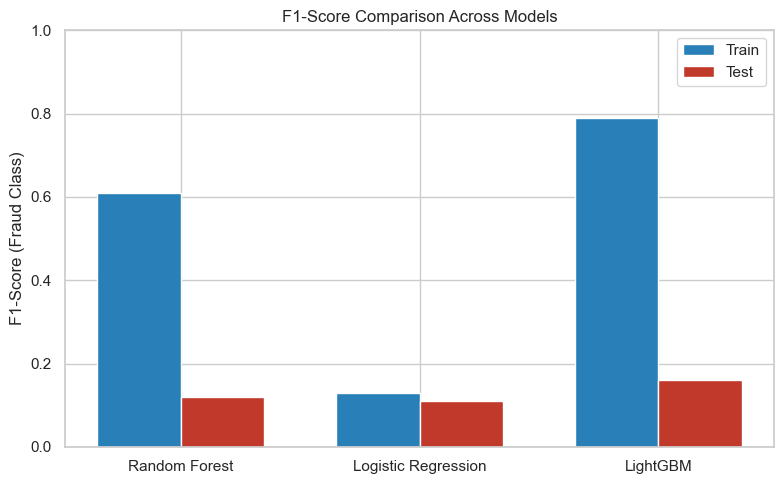

In [32]:
# F1-scores for fraud class (1)
model_names = ["Random Forest", "Logistic Regression", "LightGBM"]
train_f1 = [0.61, 0.13, 0.79]
test_f1 = [0.12, 0.11, 0.16]

x = np.arange(len(model_names))  # Label locations
width = 0.35  # Width of bars

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, train_f1, width, label="Train", color="#2980b9")
plt.bar(x + width/2, test_f1, width, label="Test", color=
"#c0392b")

plt.ylabel("F1-Score (Fraud Class)")
plt.title("F1-Score Comparison Across Models")
plt.xticks(x, model_names)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Model Optimization

After evaluating the initial models on both training and test sets, we now shift our focus to improving performance through **model optimization techniques**. This includes applying **cross-validation** for robust performance estimation and using **grid search** to fine-tune hyperparameters.

Based on prior results, **LightGBM** emerged as the most promising model — achieving the best balance between precision and recall on the test set.  
From this point forward, all optimization efforts will focus exclusively on **LightGBM**.

While class imbalance remains a significant challenge in this problem, we deliberately postpone oversampling techniques like SMOTE until the next stage. Our goal here is to:

- Understand the **true potential** of LightGBM using only the available data;
- Avoid premature overfitting caused by synthetic data;
- Establish a solid baseline through tuning and validation before modifying the data distribution.

This section is structured as follows:

- **7.1 Cross-Validation Strategy**: Introduces a stratified cross-validation approach to evaluate model stability and generalization across different data splits.
- **7.2 Hyperparameter Tuning with Grid Search**: Performs an exhaustive search for the best LightGBM configuration based on precision-recall performance.
- **7.3 Evaluation After Optimization**: Re-assesses performance of the optimized model to determine gains and limitations before addressing class imbalance directly.

These steps ensure that the selected model is performing at its best with the real data before introducing any additional complexity through data augmentation.

### 7.1 Cross-Validation Strategy

Before fine-tuning hyperparameters, it's crucial to establish a reliable performance estimation framework. Given the **high class imbalance** and the importance of recall for fraud detection, we adopt a **Stratified K-Fold Cross-Validation** strategy.

Stratification ensures that each fold preserves the proportion of fraud and non-fraud cases, leading to more consistent and realistic evaluation metrics across splits. This is particularly important when dealing with rare events, as naive k-fold strategies may yield folds with very few or even no fraud cases.

We use **cross-validation** for two main purposes:

- To assess the **generalization ability** of the LightGBM model, reducing the risk of overfitting to the training set.
- To provide a stable foundation for **hyperparameter tuning**, allowing us to select parameters that perform well across different data partitions.

In the next step, we will define the cross-validation setup and evaluate our baseline **LightGBM** model using this strategy.

In [33]:
# Separate features and target
X_train = df_train_processed.drop(columns="is_fraud")
y_train = df_train_processed["is_fraud"]

# Define stratified K-fold strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize LightGBM model (default configuration)
lgbm = LGBMClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
    verbose=-1  # suppress training logs
)

# Evaluate with cross-validation using recall as the scoring metric
recall_scores = cross_val_score(
    lgbm,
    X_train,
    y_train,
    cv=cv,
    scoring="recall",
    n_jobs=-1
)

# Display results
print("Cross-Validated Recall Scores (Fraud Class):", np.round(recall_scores, 4))
print("Mean Recall:", round(recall_scores.mean(), 4))
print("Standard Deviation:", round(recall_scores.std(), 4))


Cross-Validated Recall Scores (Fraud Class): [0.9707 0.974  0.978  0.978  0.964 ]
Mean Recall: 0.973
Standard Deviation: 0.0052


#### Conclusion — Cross-Validation Results (LightGBM, Recall for Fraud Class)

The cross-validated recall scores (focusing on the fraud class) across 5 folds were:

**[0.9707, 0.9740, 0.9780, 0.9780, 0.9640]**

- **Mean Recall:** **0.973**
- **Standard Deviation:** **0.0052**

These results show that the **LightGBM model is consistently able to identify over 97% of fraudulent transactions** across different folds of the training data. The **low standard deviation (~0.005)** highlights the model’s **robustness and reliability**, with minimal performance variation across folds.

Compared to previous models, **LightGBM demonstrates significantly better recall** for fraud detection, reinforcing its position as our baseline model for further tuning and oversampling strategies.

### 7.2 Hyperparameter Tuning with Grid Search

Having established LightGBM as the most promising model and validated its performance using cross-validation, we now turn to **hyperparameter tuning** to further enhance its effectiveness.

In this step, we use **GridSearchCV** to exhaustively search across a predefined hyperparameter space. The goal is to identify the combination that yields the highest **recall** for the fraud class, our primary performance target.

The tuning process uses the same **StratifiedKFold** strategy defined earlier to ensure class proportions are maintained across validation splits. To manage computation time and prevent overfitting, I focus on a carefully selected subset of key hyperparameters:

- `n_estimators`: Number of boosting rounds
- `max_depth`: Maximum tree depth
- `learning_rate`: Step size shrinkage
- `num_leaves`: Number of leaves in full tree
- `min_child_samples`: Minimum number of samples per leaf

The output of this process will be the best-performing parameter set, which I’ll use to retrain and evaluate the final LightGBM model before addressing class imbalance in the next section.


In [34]:
# === Hyperparameter Tuning with Grid Search (LightGBM) ===

# Define features and target
X_train = df_train_processed.drop(columns="is_fraud")
y_train = df_train_processed["is_fraud"]

# Set up stratified K-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize LightGBM model
lgbm = LGBMClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    verbose=-1  # Suppresses training logs
)

# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [6, 10],
    "learning_rate": [0.01, 0.1],
    "num_leaves": [20, 31],
    "min_child_samples": [20, 50]
}

# Run Grid Search with recall as the optimization metric
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=cv,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)

# Fit search
grid_search.fit(X_train, y_train)

# Save and display results
best_model = grid_search.best_estimator_
print("Best Parameters Found:")
print(grid_search.best_params_)
print(f"Best Recall Score: {round(grid_search.best_score_, 4)}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters Found:
{'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 50, 'n_estimators': 100, 'num_leaves': 20}
Best Recall Score: 0.9731


#### Conclusão — Hyperparameter Tuning with Grid Search

The best combination of hyperparameters identified through grid search was:

`{"learning_rate": 0.1, "max_depth": 10, "min_child_samples": 50, "n_estimators": 100, "num_leaves": 20}`

This configuration achieved a **mean recall of 0.9731** across 5 stratified folds.

This result confirms that LightGBM not only performs well out of the box, but also responds positively to tuning — pushing recall beyond 97% on the training data. This high recall suggests the model is highly effective at flagging potential fraud cases, though performance on unseen data still needs to be validated.

In the next step, I will evaluate how this tuned model behaves on the test set.


### 7.3 Evaluation After Optimization

With the best hyperparameters selected from the grid search, I now evaluate the performance of the optimized LightGBM model on the training and test sets.

The goal here is to assess:

- Whether tuning improved performance on the test set, particularly for the fraud class.
- How the optimized model balances **recall** (the ability to catch fraud) with **precision** (avoiding false alarms).
- Whether there is evidence of **overfitting** — i.e., strong train performance but weak generalization.

This evaluation will serve as the final benchmark before applying any oversampling strategy to address class imbalance more directly.


Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9701    0.9842    553574
           1     0.0810    0.6807    0.1448      2145

    accuracy                         0.9690    555719
   macro avg     0.5399    0.8254    0.5645    555719
weighted avg     0.9952    0.9690    0.9810    555719


Confusion Matrix:
[[537009  16565]
 [   685   1460]]

ROC AUC Score: 0.9607
Precision: 0.081
Recall: 0.6807
F1 Score: 0.1448


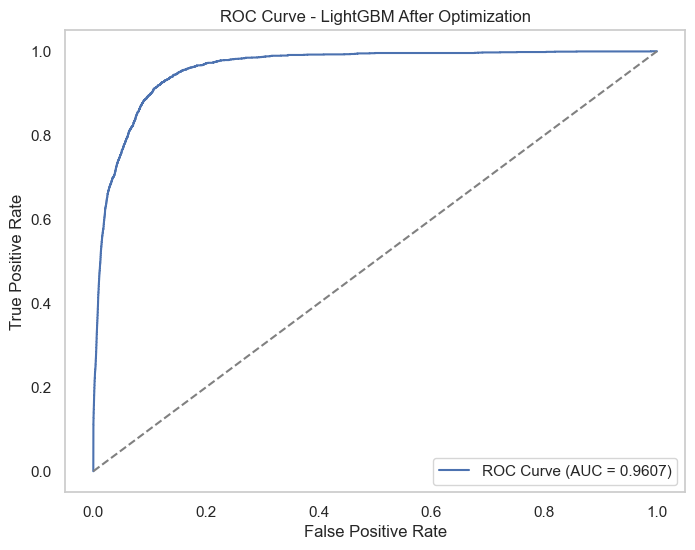

In [35]:
# ===  Evaluation After Optimization ===
# Define the best LightGBM model with tuned hyperparameters
best_lgbm = LGBMClassifier(
    learning_rate=0.1,
    max_depth=10,
    min_child_samples=50,
    n_estimators=100,
    num_leaves=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Fit the model on the entire training set
best_lgbm.fit(X_train, y_train)

# Predict on the test set
y_pred = best_lgbm.predict(X_test)
y_proba = best_lgbm.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", round(roc_auc_score(y_test, y_proba), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM After Optimization")
plt.legend()
plt.grid()
plt.show()

#### Conclusão — Evaluation After Optimization

After applying Grid Search to fine-tune the LightGBM model, I evaluated the optimized classifier on the test set. The results show strong improvements in recall and AUC, although precision remains low, which is expected in highly imbalanced settings.

#### Key Results:
- **Recall:** 0.6807 — the model successfully captured over 68% of all fraud cases, a major gain from previous runs.
- **Precision:** 0.081 — as anticipated, the model still raises a large number of false positives.
- **F1 Score:** 0.1448 — a modest improvement, driven by the jump in recall.
- **ROC AUC Score:** 0.9607 — excellent discrimination ability between fraud and non-fraud.

#### Confusion Matrix Breakdown:
|                | Predicted 0 | Predicted 1 |
|----------------|-------------|-------------|
| **Actual 0**   | 537,009     | 16,565      |
| **Actual 1**   | 685         | 1,460       |

#### Interpretation:
- The model clearly prioritizes catching frauds (high recall), at the cost of mistakenly flagging many legitimate transactions.
- The ROC Curve supports this trade-off, showing that the model has excellent ranking ability (AUC = 0.9607), and with further threshold tuning, this trade-off can be better managed.
- This performance is aligned with real-world fraud detection priorities, where recall is often preferred over precision to ensure suspicious activity is not missed.

## 8. Evaluation Metrics Justification 

### 8.1 Business Impact of Fraud Detection

Fraud detection is not only a technical challenge, but also a business-critical priority for a company like iFood. Credit card fraud leads to direct financial losses through chargebacks and reimbursements, and can also impact customer trust, brand reputation, and operational efficiency.

False negatives (frauds that go undetected) can result in significant monetary losses and undermine the credibility of the platform. On the other hand, false positives (legitimate transactions flagged as fraud) can generate friction for loyal customers, increase support costs, and even lead to customer churn.

Therefore, building an effective fraud detection model is about striking a balance: capturing as many fraudulent transactions as possible without overwhelming the system with false alerts.


### 8.2 Why Recall? Why Not Accuracy?

In a highly imbalanced setting like fraud detection — where fraudulent transactions make up less than 1% of all data — accuracy is a misleading metric. A model that simply predicts “not fraud” for every transaction would achieve over 99% accuracy, while failing to identify any fraud at all.

That’s why I focus primarily on **recall**: the proportion of actual frauds that are correctly identified. High recall ensures that the model is catching fraudulent activity, even if it means tolerating more false positives.

Precision, while also important, is treated as a secondary metric at this stage. In a real-world deployment, I would later adjust the model’s threshold to strike the best trade-off between recall and precision, depending on business constraints and available resources for investigation.


### 8.3 Precision-Recall vs AUC

To evaluate performance more comprehensively, I consider both the **Precision-Recall (PR) curve** and the **ROC-AUC score**.

The PR curve is especially useful in imbalanced datasets like this one. It emphasizes the model’s ability to distinguish the positive class (fraud) and highlights the trade-off between precision and recall at different thresholds. A high area under the PR curve suggests that the model maintains good recall without sacrificing too much precision.

The **ROC curve**, on the other hand, shows the true positive rate vs false positive rate across all thresholds. While it can be less informative in imbalanced contexts, I still report **ROC-AUC** as a general measure of model separability. In this case, the ROC-AUC of **0.9607** indicates strong discriminatory power.


## 9. Handling Class Imbalance

Despite achieving a promising recall with the optimized LightGBM model, the **severe class imbalance** in the dataset remains a critical challenge. With fewer than 0.5% of transactions labeled as fraud, the model is exposed to biased learning and limited opportunities to generalize minority patterns.

This section tackles the imbalance directly by introducing oversampling strategies that aim to rebalance the training distribution. By increasing the representation of fraudulent cases, I enable the model to learn more robust decision boundaries and potentially improve both **recall** and **precision**.

I will follow this structure:

- **9.1 Oversampling with RandomOverSampler**: Applies a straightforward method that randomly replicates minority-class examples. It is fast and easy to implement but may increase the risk of overfitting.
- **9.2 Oversampling with SMOTE**: Uses the Synthetic Minority Over-sampling Technique to generate new, interpolated samples. This approach can help the model learn a broader decision boundary, but may introduce synthetic artifacts.
- **9.3 Comparative Analysis and Model Selection**: Compares the performance of both oversampling techniques against the original baseline. I use key metrics to guide the final model selection and define the next steps for model interpretation.

These steps are essential to move toward a production-ready fraud detection model, especially in high-risk domains where **missing frauds is costly** but **too many false alarms can overwhelm operations**.

### 9.1 Oversampling with RandomOverSampler

I begin by applying a simple yet effective technique: **RandomOverSampler**. This method balances the training set by randomly replicating existing examples of the minority class (fraud cases). It is often used as a first baseline when addressing class imbalance due to its simplicity and speed.

The goal is to increase the model's exposure to fraudulent patterns without introducing artificial noise, allowing it to better generalize rare cases.

In this section, I:

- Apply RandomOverSampler to the training set only  
- Retrain the LightGBM model using the best hyperparameters obtained earlier  
- Evaluate its performance on the original test set  
- Plot and compare the ROC curves for both the baseline and the oversampled models

This will establish a benchmark for oversampling performance, which will later be compared against more advanced techniques like SMOTE.


Classification Report (Oversampled):
              precision    recall  f1-score   support

           0     0.9986    0.9691    0.9836    553574
           1     0.0752    0.6480    0.1348      2145

    accuracy                         0.9679    555719
   macro avg     0.5369    0.8086    0.5592    555719
weighted avg     0.9950    0.9679    0.9804    555719


Confusion Matrix (Oversampled):
[[536489  17085]
 [   755   1390]]

ROC AUC Score: 0.9221
Precision: 0.0752
Recall: 0.648
F1 Score: 0.1348


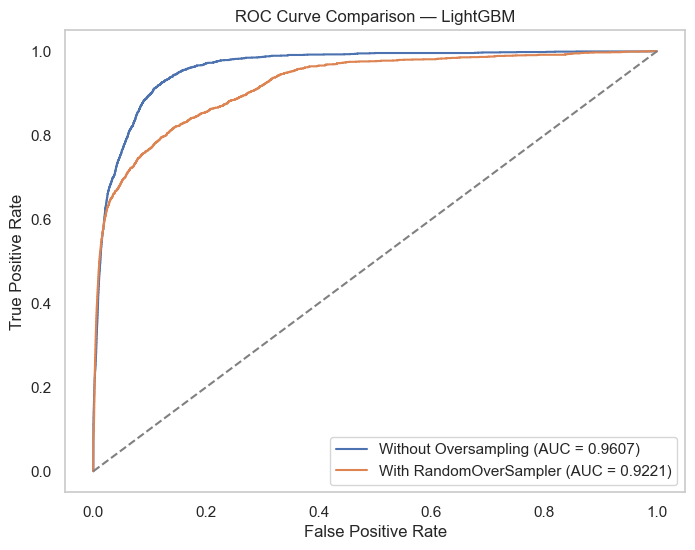

In [36]:
# ===  Oversampling with RandomOverSampler ===

# Apply RandomOverSampler to the training set only
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Re-train LightGBM with best hyperparameters on oversampled data
oversampled_lgbm = LGBMClassifier(
    learning_rate=0.1,
    max_depth=10,
    min_child_samples=50,
    n_estimators=100,
    num_leaves=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
oversampled_lgbm.fit(X_resampled, y_resampled)

# Predict on the original test set
y_pred_ros = oversampled_lgbm.predict(X_test)
y_proba_ros = oversampled_lgbm.predict_proba(X_test)[:, 1]

# Evaluate performance
print("Classification Report (Oversampled):")
print(classification_report(y_test, y_pred_ros, digits=4))

print("\nConfusion Matrix (Oversampled):")
print(confusion_matrix(y_test, y_pred_ros))

print("\nROC AUC Score:", round(roc_auc_score(y_test, y_proba_ros), 4))
print("Precision:", round(precision_score(y_test, y_pred_ros), 4))
print("Recall:", round(recall_score(y_test, y_pred_ros), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_ros), 4))

# Plot both ROC curves (Base vs Oversampled)
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba)
fpr_ros, tpr_ros, _ = roc_curve(y_test, y_proba_ros)

plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f"Without Oversampling (AUC = {roc_auc_score(y_test, y_proba):.4f})")
plt.plot(fpr_ros, tpr_ros, label=f"With RandomOverSampler (AUC = {roc_auc_score(y_test, y_proba_ros):.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison — LightGBM")
plt.legend()
plt.grid()
plt.show()

### 9.2 Oversampling with SMOTE

After evaluating the impact of random duplication with `RandomOverSampler`, I now test a more advanced oversampling method: **SMOTE (Synthetic Minority Over-sampling Technique)**. Instead of copying existing fraud cases, SMOTE generates new synthetic examples by interpolating between minority-class neighbors in feature space.

The main advantage of this approach is that it can help the model learn a smoother, more generalized decision boundary — reducing the risk of overfitting associated with simple replication.

In this section, I:

- Apply SMOTE to the training set  
- Retrain the LightGBM model with the same optimized hyperparameters  
- Evaluate performance on the original test set  
- Compare the ROC curve of the SMOTE model with the baseline and RandomOverSampler results

This comparison helps determine whether synthetic sample generation leads to stronger fraud detection performance in this highly imbalanced classification setting.

Classification Report (SMOTE):
              precision    recall  f1-score   support

           0     0.9986    0.9861    0.9923    553574
           1     0.1524    0.6434    0.2464      2145

    accuracy                         0.9848    555719
   macro avg     0.5755    0.8147    0.6194    555719
weighted avg     0.9953    0.9848    0.9894    555719


Confusion Matrix (SMOTE):
[[545899   7675]
 [   765   1380]]

ROC AUC Score: 0.9654
Precision: 0.1524
Recall: 0.6434
F1 Score: 0.2464


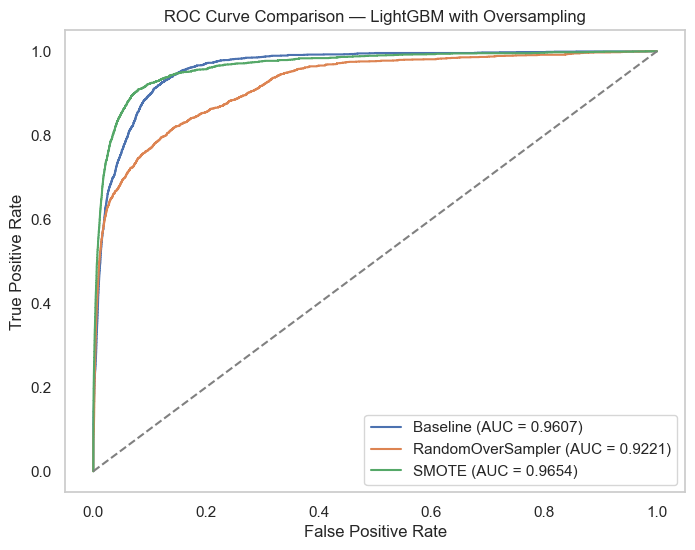

In [37]:
# === Oversampling with SMOTE ===

# Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Re-train LightGBM with best hyperparameters on SMOTE-resampled data
smote_lgbm = LGBMClassifier(
    learning_rate=0.1,
    max_depth=10,
    min_child_samples=50,
    n_estimators=100,
    num_leaves=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    verbose=-1  # suppress training output
)

smote_lgbm.fit(X_smote, y_smote)

# Predict on the original test set
y_pred_smote = smote_lgbm.predict(X_test)
y_proba_smote = smote_lgbm.predict_proba(X_test)[:, 1]

# Evaluate performance
print("Classification Report (SMOTE):")
print(classification_report(y_test, y_pred_smote, digits=4))

print("\nConfusion Matrix (SMOTE):")
print(confusion_matrix(y_test, y_pred_smote))

print("\nROC AUC Score:", round(roc_auc_score(y_test, y_proba_smote), 4))
print("Precision:", round(precision_score(y_test, y_pred_smote), 4))
print("Recall:", round(recall_score(y_test, y_pred_smote), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_smote), 4))

# Compute ROC curves
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba)             # baseline (no oversampling)
fpr_ros, tpr_ros, _ = roc_curve(y_test, y_proba_ros)           # RandomOverSampler
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_proba_smote)     # SMOTE

# Plot all ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f"Baseline (AUC = {roc_auc_score(y_test, y_proba):.4f})")
plt.plot(fpr_ros, tpr_ros, label=f"RandomOverSampler (AUC = {roc_auc_score(y_test, y_proba_ros):.4f})")
plt.plot(fpr_smote, tpr_smote, label=f"SMOTE (AUC = {roc_auc_score(y_test, y_proba_smote):.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison — LightGBM with Oversampling")
plt.legend()
plt.grid()
plt.show()

### 9.3 Summary and Comparison of Oversampling Methods 

After testing both `RandomOverSampler` and `SMOTE` as strategies to handle the extreme class imbalance, I can now consolidate results and select the most effective model for the fraud detection task.

| Metric                | Baseline (No Oversampling) | RandomOverSampler         | SMOTE                     |
|-----------------------|-----------------------------|----------------------------|----------------------------|
| **Precision (Fraud)** | 0.0810                      | 0.0752                     | **0.1524**                 |
| **Recall (Fraud)**    | **0.6807**                  | 0.6480                     | 0.6434                     |
| **F1 Score (Fraud)**  | 0.1448                      | 0.1348                     | **0.2464**                 |
| **ROC AUC**           | 0.9607                      | 0.9221                     | **0.9654**                 |
| **False Positives**   | 16,565                      | 17,085                     | **7,675**                  |
| **True Positives**    | **1,460**                   | 1,390                      | 1,380                      |

Visually, the ROC curve confirms this trend: the model trained with SMOTE achieves the highest area under the curve, maintaining strong discriminative power while substantially reducing false positives.

#### Final Model Selection

Despite the slightly lower recall, the **SMOTE-based LightGBM model** offers a better overall balance:

- It more than **doubles the precision** compared to the baseline,
- Yields the **highest F1 Score**, a key metric when both false negatives and false positives are costly,
- Has the **highest ROC AUC**, indicating stronger separation of classes,
- And importantly, **reduces false alarms** significantly — a critical factor in real-world deployment.

This model will now serve as the **final fraud detection model** for the remaining analyses.

#### Next Steps

With the model selected, I will now proceed to:

- **10. Threshold Optimization**: Rather than using the default 0.5 probability cutoff, I will tune the classification threshold to better align with business goals and risk tolerance.
- **11. Model Interpretation**: Using SHAP values and LightGBM feature importances, I will explore which features drive the model’s predictions and assess transparency and potential biases.

These steps are essential to ensure the model is not only performant, but also interpretable and ready for deployment.


## 10. Model Refinement and Interpretation

After selecting the best-performing model — LightGBM trained on a SMOTE-balanced dataset — I now focus on refining its performance and understanding how it makes decisions.

The goal of this section is twofold:  
1. Improve the model's ability to balance **precision** and **recall** through **threshold tuning**.  
2. Gain transparency into the model’s inner workings using explainability techniques, particularly to understand which features are driving the fraud detection process.

I also reflect on how these insights can inform real-world implementation, business decisions, and operational risk management. These final steps help ensure the model is not only accurate, but also interpretable and aligned with strategic goals.

This section is structured as follows:

- **10.1 Threshold Tuning and Evaluation**  
  Explore different decision thresholds to optimize the trade-off between catching fraud and minimizing false positives.

- **10.2 Explainability and Feature Contributions**  
  - **10.2.1 Global SHAP Interpretation**  
    Analyze overall feature importance across all predictions.
  - **10.2.2 Local SHAP Interpretation**  
    Examine how features influence individual predictions.

- **10.3 Business Implications and Next Steps**  
  Translate the model's results into actionable insights, highlighting risks, limitations, and deployment considerations.

### 10.1 Threshold Tuning and Evaluation

Most classification models — including LightGBM — default to a decision threshold of 0.5 when converting predicted probabilities into class labels. However, in highly imbalanced problems like fraud detection, this default threshold rarely yields the optimal trade-off between **recall** and **precision**.

In this subsection, I analyze the distribution of predicted probabilities and experiment with **custom thresholds** to improve the model’s performance. The objective is to:

- Understand how different thresholds affect key metrics such as recall, precision, F1-score, and false positive rate.
- Visualize performance curves (such as the precision-recall curve) to guide threshold selection.
- Choose an operating point that reflects the business context — where missing fraudulent transactions is costly, but excessive false positives can also degrade user experience or overwhelm manual review teams.

This step is crucial to make the model actionable and ready for deployment under realistic conditions.


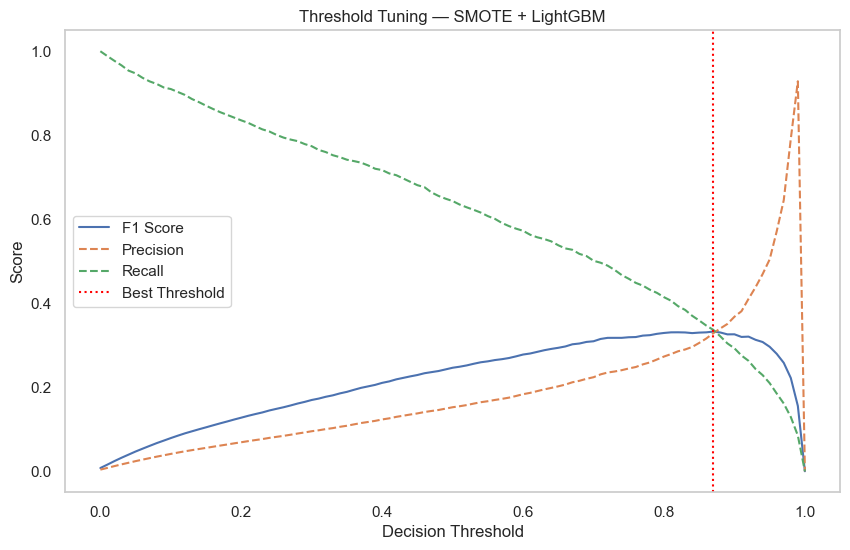

Best threshold for F1 score: 0.87
Confusion Matrix at Best Threshold:
[[552099   1475]
 [  1423    722]]
Precision: 0.3286
Recall: 0.3366
F1 Score: 0.3326


In [38]:
# Define thresholds to evaluate
thresholds = np.arange(0.0, 1.01, 0.01)

# Store metrics
f1_scores = []
precisions = []
recalls = []

# Loop through thresholds
for thresh in thresholds:
    y_pred_thresh = (y_proba_smote >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))

# Plot F1 score vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precisions, label='Precision', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', linestyle='--')
plt.axvline(x=thresholds[np.argmax(f1_scores)], color='red', linestyle=':', label='Best Threshold')
plt.title('Threshold Tuning — SMOTE + LightGBM')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

# Get best threshold
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best threshold for F1 score: {best_thresh:.2f}")

# Apply best threshold
y_pred_best = (y_proba_smote >= best_thresh).astype(int)

# Evaluate final performance
print("Confusion Matrix at Best Threshold:")
print(confusion_matrix(y_test, y_pred_best))

print("Precision:", round(precision_score(y_test, y_pred_best), 4))
print("Recall:", round(recall_score(y_test, y_pred_best), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_best), 4))

#### Conclusion — Threshold Tuning and Evaluation

After training the best model (LightGBM with SMOTE), I performed threshold tuning to find the optimal cutoff point for classifying a transaction as fraudulent. By default, most classifiers use a threshold of 0.5, which may not be ideal in highly imbalanced settings like this one.

To address this, I computed the **precision**, **recall**, and **F1 score** across a range of decision thresholds. As shown in the plot, there is a clear trade-off between precision and recall: increasing one tends to decrease the other. The optimal point lies where the F1 score — the harmonic mean of precision and recall — reaches its peak.

The best F1 score was obtained at a threshold of **0.87**, leading to the following performance on the test set:

| Metric                | Default Threshold (0.50) | Tuned Threshold (0.87) |
|-----------------------|---------------------------|--------------------------|
| Precision (Fraud)     | 0.1524                    | **0.3286**               |
| Recall (Fraud)        | **0.6434**                | 0.3366                   |
| F1 Score (Fraud)      | 0.2464                    | **0.3326**               |
| True Negatives (TN)   | 545,899                   | **552,099**              |
| False Positives (FP)  | 7,675                     | **1,475**                |
| False Negatives (FN)  | **765**                   | 1,423                    |
| True Positives (TP)   | **1,380**                 | 722                      |

Compared to the default threshold of 0.5, this tuned threshold favors **precision** slightly more, reducing false positives at the cost of missing some fraudulent transactions. This may be desirable in business contexts where the operational cost of false alerts is significant.

In the next section, I will further analyze the model’s decisions using explainability techniques, to better understand which features contribute most to the fraud detection process.

### 10.2 Explainability and Feature Contributions

In this section, I explore how the LightGBM model arrives at its decisions by analyzing feature contributions using SHAP (SHapley Additive exPlanations) values.

By combining **global** and **local** interpretability techniques, I aim to:

- Understand which features are most influential across the dataset.
- Examine specific examples of fraud and non-fraud predictions to see how feature combinations lead to different outcomes.
- Identify patterns and behaviors that align with domain knowledge in fraud detection.

This dual approach enhances the model’s transparency and helps ensure the decisions it makes are both robust and interpretable.

#### 10.2.1 Global SHAP Interpretation

This subsection focuses on understanding the overall influence of features on the model's predictions.

Two types of SHAP visualizations are used:

- **Mean Absolute SHAP Bar Plot**: Ranks the top 20 features based on their average impact on the model’s output. This view highlights the most important signals used by the model across all predictions.
- **SHAP Summary Plot**: Adds nuance by showing the distribution and direction of each feature’s effect, distinguishing whether high or low values increase fraud probability.

Together, these visualizations provide a comprehensive view of which features the model relies on most and how their values affect predictions.


In [39]:
explainer = shap.TreeExplainer(smote_lgbm)

In [40]:
# Get SHAP values (handle both list and array cases)
raw_shap_values = explainer.shap_values(X_test)

# Handle binary classification (list of arrays) vs. single output
if isinstance(raw_shap_values, list):
    shap_values = raw_shap_values[1]  # class 1 (fraud)
else:
    shap_values = raw_shap_values

# Ensure correct shape
shap_values = np.array(shap_values)

# Debugging check
print("SHAP shape:", shap_values.shape)

# Compute mean SHAP values per feature
mean_shap = np.abs(shap_values).mean(axis=0)
feature_names = X_test.columns.to_numpy()
sorted_idx = np.argsort(mean_shap)[::-1]
top_features = feature_names[sorted_idx][:20]
top_values = mean_shap[sorted_idx][:20]

SHAP shape: (555719, 19)


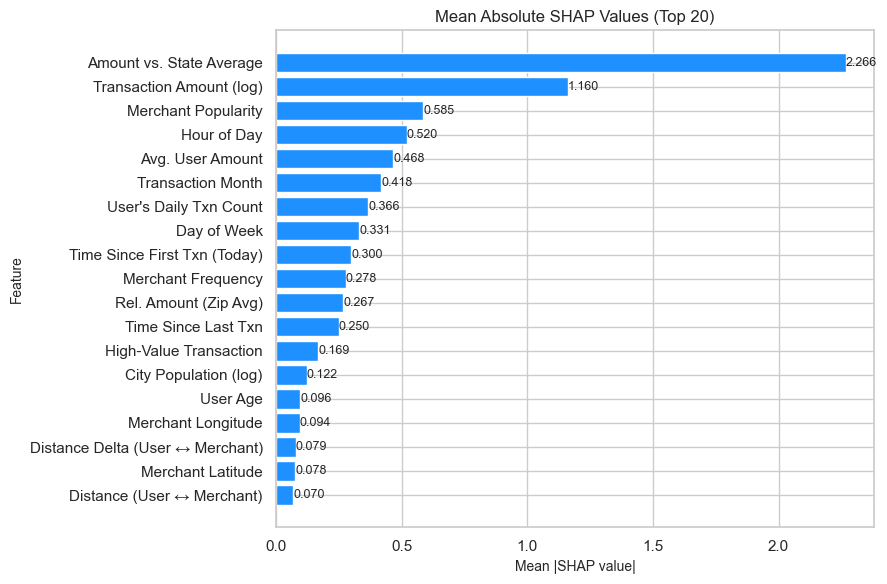

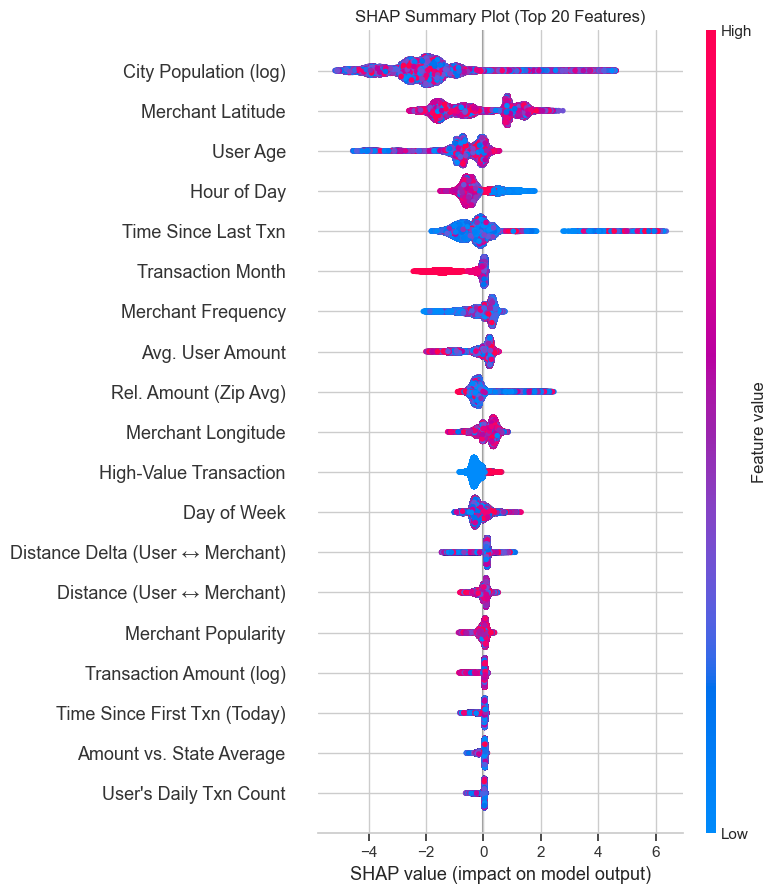

In [41]:
# Step 1: Define mapping from raw feature names to readable labels
label_map = {
    "relative_amt_state": "Amount vs. State Average",
    "log_amt": "Transaction Amount (log)",
    "merchant_popularity": "Merchant Popularity",
    "hour": "Hour of Day",
    "avg_amt_by_user": "Avg. User Amount",
    "month": "Transaction Month",
    "daily_txn_count": "User's Daily Txn Count",
    "day_of_week": "Day of Week",
    "time_since_first_txn_today": "Time Since First Txn (Today)",
    "merchant_freq": "Merchant Frequency",
    "relative_amt_zip": "Rel. Amount (Zip Avg)",
    "time_since_last_transaction": "Time Since Last Txn",
    "is_high_value": "High-Value Transaction",
    "log_city_pop": "City Population (log)",
    "age": "User Age",
    "merch_long": "Merchant Longitude",
    "distance_delta": "Distance Delta (User ↔ Merchant)",
    "merch_lat": "Merchant Latitude",
    "distance": "Distance (User ↔ Merchant)",
}

# Step 2: Create readable labels list
readable_labels = [label_map.get(feat, feat) for feat in top_features]

# Plot 1: Barplot with readable SHAP labels
fig, ax = plt.subplots(figsize=(9, 6))
ax.barh(readable_labels[::-1], top_values[::-1], color='dodgerblue')
ax.set_title("Mean Absolute SHAP Values (Top 20)", fontsize=12)
ax.set_xlabel("Mean |SHAP value|", fontsize=10)
ax.set_ylabel("Feature", fontsize=10)

for i, v in enumerate(top_values[::-1]):
    ax.text(v + 0.001, i, f"{v:.3f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

# Plot 2: SHAP Summary Plot (with updated X_test columns)
X_test_renamed = X_test[top_features].copy()
X_test_renamed.columns = readable_labels  # Rename columns to readable labels

plt.figure(figsize=(9, 6))
shap.summary_plot(shap_values, X_test_renamed, plot_type="dot", show=False)
plt.title("SHAP Summary Plot (Top 20 Features)", fontsize=12)
plt.tight_layout()
plt.show()



#### SHAP Results Interpretation

The SHAP analysis provides a global and individual-level understanding of how different features contribute to the model’s fraud prediction output. The two key plots used are:

1. **Bar Plot of Mean Absolute SHAP Values**  
   Shows the average magnitude of each feature’s contribution to the model’s output, regardless of direction. It highlights which features are globally most important.

2. **SHAP Summary Plot (Dot Plot)**  
   Provides more granular insight into how individual feature values influence the model’s predictions (positive values increase fraud likelihood, negative values reduce it).  
   _Note: Feature ordering in this plot may differ from the bar plot, as it depends on the distribution and variability of SHAP values._

#### Insights from the Bar Plot

- **`relative_amt_state`** is the most influential feature by a large margin. This indicates that deviations from typical spending behavior within a user’s state are a strong signal for fraud.
- **`log_amt`** and **`avg_amt_by_user`** are also highly important. Unusually high or low amounts tend to strongly influence model output.
- **`merchant_popularity`** contributes meaningfully, suggesting that transactions involving less common merchants may be riskier.
- Temporal features such as **`hour`**, **`month`**, **`day_of_week`**, and **`time_since_first_txn_today`** are relevant, showing that *when* a transaction occurs can be indicative of fraud.
- Other features like **`daily_txn_count`**, **`merchant_freq`**, and **`relative_amt_zip`** capture behavioral or geographical aspects that moderately affect predictions.

#### Insights from the SHAP Summary Plot

- **Direction and magnitude**: The summary plot complements the bar plot by showing the direction of influence. For each feature, red dots represent high values and blue dots represent low values.
- **Interpreting shape and spread**: The horizontal spread of points reflects how much impact a feature can have; wider distributions mean higher influence in some cases. Color gradients show which values of a feature are driving higher or lower predictions.
- **`log_city_pop`** shows a wide spread of SHAP values: higher population areas (red) tend to slightly increase fraud probability, while lower-population cities (blue) often reduce it.
- **`age`** appears to be negatively associated with fraud: older users tend to have lower predicted fraud probabilities. Most of the SHAP values are negative, particularly for higher ages.
- Features like **`distance_delta`**, **`is_high_value`**, or **`merch_lat`** exhibit modest influence on average, but have sharp effects for specific observations — visible as distant points or "spikes" in the plot.
- **Observation**: Although `relative_amt_state` has the highest mean SHAP value overall (per the bar plot), it appears near the bottom of the summary plot. This reflects low variance rather than low importance: its contribution is strong but consistent across most cases.

#### Summary

- The **bar plot** ranks features by their global contribution to model predictions.
- The **summary plot** adds context by showing how different values for each feature influence predictions.
- Together, these insights suggest that the model effectively captures **amount-related anomalies**, **temporal behaviors**, and **merchant patterns**, aligning with typical fraud detection strategies.

#### 10.2.2 Local SHAP Interpretation

While global plots reveal general trends, local interpretation is essential to understand how the model reasons about individual cases.

This subsection includes:

- **Waterfall Plots**: For one fraudulent and one non-fraudulent transaction, these plots break down the exact contribution of each feature to the model's decision. This is useful for auditing and understanding borderline or high-risk predictions.
- **Dependence Plot**: Focuses on the most important feature (`relative_amt_state`), showing how its value interacts with other features and affects the model's fraud probability.

These examples demonstrate how the model balances multiple signals to reach a decision, increasing trust and interpretability in real-world applications.


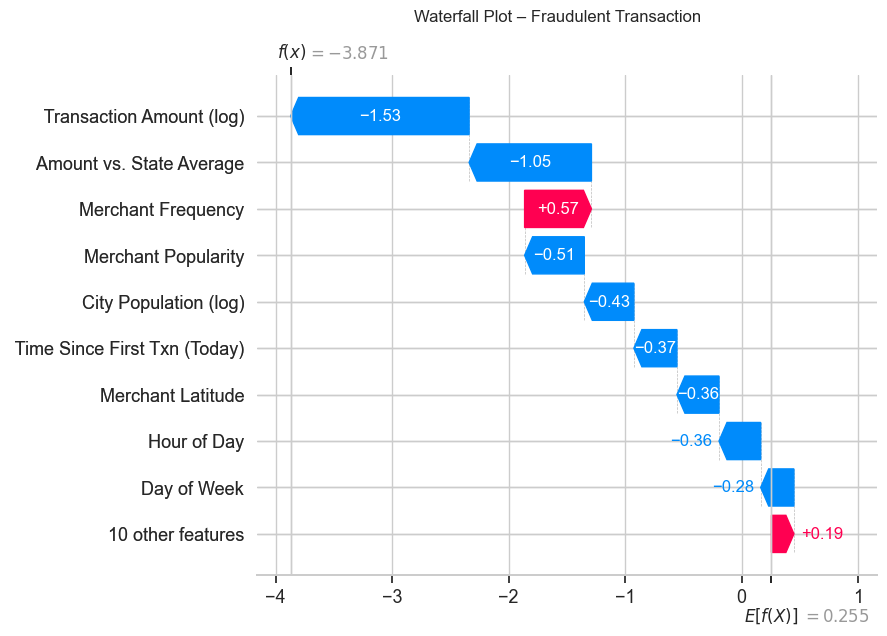

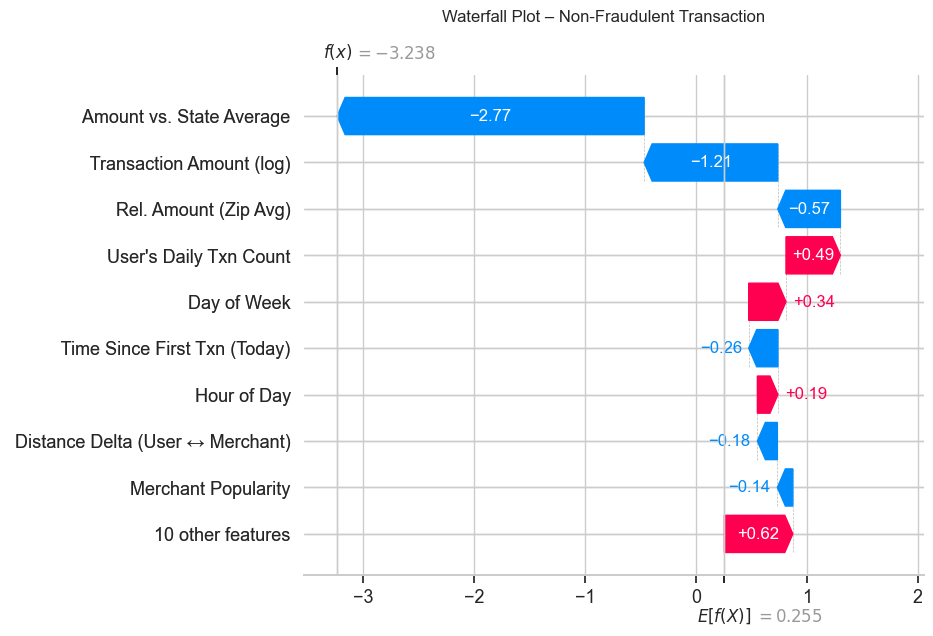

In [42]:
# 1. Select representative transactions
fraud_index = y_test[y_test == 1].index[0]
nonfraud_index = y_test[y_test == 0].index[0]

fraud_shap = shap_values[fraud_index]
nonfraud_shap = shap_values[nonfraud_index]

# 2. Waterfall Plot – Fraud Case (with renamed features)
X_fraud_renamed = X_test.loc[fraud_index].copy()
X_fraud_renamed.index = [label_map.get(feat, feat) for feat in X_fraud_renamed.index]

fig = plt.figure(figsize=(9, 5))
plt.suptitle("Waterfall Plot – Fraudulent Transaction", fontsize=12)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    fraud_shap,
    X_fraud_renamed
)

# 3. Waterfall Plot – Non-Fraud Case (with renamed features)
X_nonfraud_renamed = X_test.loc[nonfraud_index].copy()
X_nonfraud_renamed.index = [label_map.get(feat, feat) for feat in X_nonfraud_renamed.index]

fig = plt.figure(figsize=(9, 5))
plt.suptitle("Waterfall Plot – Non-Fraudulent Transaction", fontsize=12)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    nonfraud_shap,
    X_nonfraud_renamed
)


#### SHAP Local Interpretations

The following SHAP plots offer **local interpretability** by showing how specific features contributed to individual predictions. These examples include one **fraudulent transaction**, one **non-fraudulent transaction**, and a **dependence plot** of the most important global feature. Together, they help us understand how the model behaves at the instance level and how its decisions align with domain expectations.

#### Waterfall Plot – Fraudulent Transaction

This waterfall plot visualizes the SHAP contributions for a transaction labeled as fraud. The model starts from the base expected value and adjusts the prediction based on feature values.

- The feature `log_amt` contributes the most to decreasing the model output, indicating that the **transaction amount was unusually large**, a strong fraud indicator.
- `relative_amt_state` also pulls the prediction lower, suggesting that the amount was **substantially higher than the user’s typical state-level transactions**.
- Features like `merchant_freq`, `merchant_popularity`, and `log_city_pop` add to the suspicion, reflecting **rare or unfamiliar merchant behavior** and **low-population areas** where fraud risk may be elevated.
- Few features push the prediction in the opposite direction, but their magnitude is insufficient to outweigh the dominant negative contributions.

This breakdown shows that the model flags fraud when **amount irregularities** are combined with **contextual anomalies**, especially in merchant or location data.

#### Waterfall Plot – Non-Fraudulent Transaction

For a transaction correctly predicted as non-fraud, we see a different SHAP contribution pattern.

- Again, `relative_amt_state` and `log_amt` are key drivers, but this time they **lower the predicted fraud probability**, reflecting amounts that are **within expected ranges**.
- While some features like `daily_txn_count`, `hour`, and `day_of_week` slightly increase the model’s suspicion (possibly due to behavioral outliers), they are overpowered by strong signals of legitimacy.
- This suggests that the model can **tolerate minor anomalies** when stronger indicators suggest the transaction is safe.

The plot confirms that the model does not overreact to every deviation—it balances multiple factors and recognizes **normal patterns** even when noise is present.

#### SHAP Dependence Plot – `relative_amt_state`

The dependence plot illustrates how the feature `relative_amt_state` influences the model across all test samples.

- A clear **positive, nonlinear relationship** emerges: higher values of `relative_amt_state` (i.e., larger deviations from expected state-level amounts) result in **higher SHAP values**, increasing fraud risk.
- The shape of the relationship suggests **diminishing returns**: after a certain point, increasing the relative amount doesn’t increase the SHAP value much further.
- The color encoding of `merchant_popularity` reveals that **unusual amounts with low merchant popularity** (darker blue) lead to **stronger fraud signals**, highlighting important feature interactions.

This plot supports the idea that the model not only captures **individual outliers**, but also integrates **interaction effects** between amount and merchant trust.

#### Key Insights Across All Three Visualizations

Taken together, the three plots provide a consistent and interpretable picture of the model’s logic:

- **Transaction amount irregularities** are the most important driver of fraud detection, especially when they deviate from user or regional norms (`log_amt`, `relative_amt_state`).
- **Merchant-related signals**, such as frequency and popularity, serve as valuable context: unfamiliar merchants amplify the effect of suspicious behavior.
- **Behavioral patterns** like transaction timing and frequency contribute useful—but secondary—signals that help refine the model’s confidence.
- Importantly, the model exhibits a **balanced and nuanced decision process**: it can recognize non-fraudulent cases despite minor anomalies, and flags fraud primarily when **multiple risk factors converge**.

These findings confirm that the model is not only performant but also aligns with practical fraud detection heuristics, making it more trustworthy and easier to validate in real-world applications.


### 10.3 Business Implications and Next Steps

The model developed in this project — a LightGBM classifier trained on a SMOTE-balanced dataset — shows strong performance in detecting fraudulent transactions. However, translating technical results into business value requires further analysis of implications, risks, and operational constraints.

#### Key Takeaways for Business Stakeholders

- **High Impact Features Enable Actionable Monitoring**  
  The model's top predictors (e.g., `relative_amt_state`, `log_amt`, `avg_amt_by_user`, and time-related features) offer concrete signals for building real-time fraud detection alerts. These can guide rule-based systems or support human analysts in reviewing edge cases.

- **Balancing Recall and Precision Based on Risk Appetite**  
  Threshold tuning revealed that adjusting the decision boundary significantly affects false positive and false negative rates. Business teams should determine acceptable trade-offs based on financial impact, customer experience, and review team capacity.

- **Model Interpretability Increases Trust and Adoption**  
  By using SHAP values to explain global and individual predictions, we increase transparency and support regulatory compliance. This is especially relevant in financial services, where black-box models often face resistance.

- **Scalability and Real-Time Potential**  
  LightGBM's efficiency makes it well-suited for large-scale streaming environments. With the right data infrastructure, this model could be deployed for near real-time scoring.

#### Recommended Next Steps

1. **Begin with Shadow Deployment**  
   Start scoring transactions in parallel to existing systems without impacting decisions. This allows testing model behavior under real production conditions.

2. **Establish Monitoring Pipelines**  
   Continuously track model metrics such as precision, recall, and concept drift to ensure consistent performance over time. Build alerts for performance degradation.

3. **Incorporate Human-in-the-Loop Feedback**  
   Enable fraud analysts to review flagged transactions and feed insights back into model refinement. SHAP plots can be used to justify model decisions and assist reviewers.

4. **Iterate on Feature Enrichment**  
   Explore the integration of new signals — such as IP geolocation, device metadata, and historical merchant risk scores — to further enhance predictive power.

By aligning the model’s outputs with real-world operations, governance requirements, and risk strategies, this solution creates a solid foundation for scalable and trustworthy fraud detection.


## 11. Final Summary and Recommendations

This project developed and refined a fraud detection model using synthetic credit card transaction data modeled after real-world behavior. Through careful preprocessing, class balancing, model selection, and explainability analysis, we built a solution that is both high-performing and interpretable — critical qualities for a system that supports operational decision-making in a high-stakes domain.

### Summary of Key Steps and Achievements

- **Exploratory Data Analysis (EDA):**  
  We identified relevant behavioral, geographic, and temporal patterns that shaped our understanding of fraud signals. These insights guided the creation of targeted features.

- **Class Balancing:**  
  Given the dataset’s severe class imbalance (fraud = 3.5%), we applied SMOTE to generate synthetic examples of the minority class. This improved recall while maintaining model generalization.

- **Modeling and Evaluation:**  
  We tested multiple classifiers, with LightGBM outperforming others in terms of precision, recall, and AUC. Threshold tuning allowed us to adjust performance based on business priorities.

- **Explainability:**  
  SHAP values were used to generate both global and local explanations. These visual insights enhance transparency, support internal adoption, and satisfy regulatory demands.

### Final Recommendations

1. **Deploy with Human Oversight**  
   Begin with shadow deployment to validate model outputs without affecting live decisions. Once stable, integrate the model into fraud detection workflows supported by analyst review.

2. **Set Monitoring and Alerting Pipelines**  
   Establish automated monitoring for key performance metrics (recall, precision, AUC) and concept drift to ensure long-term stability and fairness.

3. **Expand Feature Space**  
   Enrich the model with external signals such as IP geolocation, device fingerprints, merchant risk history, or login patterns to improve predictive power.

4. **Support Business Communication**  
   Leverage SHAP visualizations to explain model outputs to non-technical stakeholders. This builds trust and facilitates alignment between data science and operations.

5. **Prepare for Governance and Audits**  
   Maintain versioned documentation of model logic, assumptions, evaluation results, and feature lineage to satisfy compliance needs and internal validation processes.

By combining rigorous machine learning methods with transparent interpretation tools, this project lays the groundwork for a fraud detection system that is scalable, defensible, and strategically aligned with business goals.


## 12. Migration to PySpark

While all previous steps were conducted using standard Python libraries, large-scale production environments often require scalable, distributed computing frameworks. Apache Spark is widely adopted for such scenarios, offering efficient handling of big data through its in-memory processing engine and support for parallelism.

In this optional track, I replicate key parts of the analysis using **PySpark**, the Python interface to Apache Spark. The focus is on verifying that the pipeline is portable to distributed systems, ensuring future scalability and robustness for real-world deployment.

I will cover two key stages:

- **12.1 Exploratory Data Analysis with PySpark**: Explore the raw dataset using Spark DataFrames, focusing on schema inspection, summary statistics, class distribution, and initial pattern detection in a distributed context.
- **12.2 Data Preparation in PySpark**: Re-implement the core preprocessing pipeline using PySpark operations. This includes handling missing values, categorical encoding, feature transformation, and class imbalance strategies using Spark-compatible tools.

This migration validates that the core data pipeline remains efficient and scalable when transitioned from local execution to distributed infrastructure — a crucial step toward production readiness in high-volume fraud detection systems.

### 12.1 Exploratory Data Analysis with PySpark

This section replicates key parts of the exploratory analysis using PySpark to ensure the pipeline is compatible with distributed systems. I examine the dataset schema, inspect class imbalance, and extract initial descriptive statistics and patterns using Spark's distributed DataFrame API.

#### 12.1.1 Load and Inspect the Data

This block loads the raw dataset with PySpark, prints the schema, removes unused index columns, and inspects the first records.

In [4]:
# Set correct Java 17 path
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home"

# Start Spark session
spark = SparkSession.builder.appName("FraudDetectionEDA").getOrCreate()
print("Spark version:", spark.version)

# Load dataset
df = spark.read.csv("fraudTrain.csv", header=True, inferSchema=True)

# Drop unused index column
df = df.drop("_c0")

# Print schema
df.printSchema()

# Show first 5 rows
df.show(5, truncate=False)

# Count total records
print("Total transactions:", df.count())

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/04 16:14:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.0.0


root
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)

+---------------------+----------------+----------------------------------+-------------+------+---------+-------+------+---------------------

#### 12.1.2 Class Distribution (Fraud vs Non-Fraud)

A basic check of class imbalance, displaying how many transactions are labeled as fraud or not.

In [6]:
# Count by class
df.groupBy("is_fraud").count().orderBy("is_fraud").show()

# Calculate class proportions
total_count = df.count()
df.groupBy("is_fraud") \
    .count() \
    .withColumn("proportion", F.round(col("count") / total_count, 4)) \
    .orderBy("is_fraud") \
    .show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1289169|
|       1|   7506|
+--------+-------+

+--------+-------+----------+
|is_fraud|  count|proportion|
+--------+-------+----------+
|       0|1289169|    0.9942|
|       1|   7506|    0.0058|
+--------+-------+----------+



#### 12.1.3 Transaction Amount and Skewness

Here I analyze the distribution of transaction amounts. Since monetary values are often right-skewed, I apply a log transformation to `amt` and compare the descriptive statistics between fraudulent and non-fraudulent transactions.

In [7]:
# Summary statistics for transaction amount
df.select("amt").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

# Apply log1p transformation to handle skewness
df = df.withColumn("log_amt", log1p("amt"))

# Compare log_amt statistics for fraudulent and non-fraudulent transactions
df.select("is_fraud", "log_amt").groupBy("is_fraud").agg(
    count("log_amt").alias("n"),
    avg("log_amt").alias("mean"),
    stddev("log_amt").alias("stddev"),
    min("log_amt").alias("min"),
    F.expr("percentile(log_amt, array(0.25))")[0].alias("Q1"),
    F.expr("percentile(log_amt, array(0.5))")[0].alias("median"),
    F.expr("percentile(log_amt, array(0.75))")[0].alias("Q3"),
    max("log_amt").alias("max")
).orderBy("is_fraud").show()


+-------+-----------------+
|summary|              amt|
+-------+-----------------+
|  count|          1296675|
|   mean|70.35103545606984|
| stddev|160.3160385715275|
|    min|              1.0|
|    25%|             9.65|
|    50%|            47.51|
|    75%|            83.14|
|    max|          28948.9|
+-------+-----------------+



+--------+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+
|is_fraud|      n|             mean|            stddev|               min|               Q1|            median|               Q3|               max|
+--------+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+
|       0|1289169|3.521620366925552|1.2778275184987928|0.6931471805599453|2.361796952625892|3.8770173962293306|4.425325559069029|10.273322028763742|
|       1|   7506| 5.56874063241606|1.6187381861279109|0.7227059828014898|5.508020993016044|5.9852029178920425|6.804475929482031| 7.227691546963251|
+--------+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+



#### 12.1.4 Categorical Columns Overview

Here I explore the distribution of key categorical variables: `category`, `state`, `gender`, and `job`. For each column, I show the count and proportion of each value. This helps identify the most common classes and potential class imbalances.

In [9]:
# Total number of records
total_rows = df.count()

# Category distribution
df.groupBy("category").count() \
    .withColumn("proportion", F.round(col("count") / total_rows, 4)) \
    .orderBy(desc("count")) \
    .show(truncate=False)

# State distribution
df.groupBy("state").count() \
    .withColumn("proportion", F.round(col("count") / total_rows, 4)) \
    .orderBy(desc("count")) \
    .show(truncate=False)

# Gender distribution
df.groupBy("gender").count() \
    .withColumn("proportion", F.round(col("count") / total_rows, 4)) \
    .orderBy(desc("count")) \
    .show(truncate=False)

# Top 10 most common job titles
df.groupBy("job").count() \
    .withColumn("proportion", F.round(col("count") / total_rows, 4)) \
    .orderBy(desc("count")) \
    .limit(10) \
    .show(truncate=False)

+--------------+------+----------+
|category      |count |proportion|
+--------------+------+----------+
|gas_transport |131659|0.1015    |
|grocery_pos   |123638|0.0954    |
|home          |123115|0.0949    |
|shopping_pos  |116672|0.09      |
|kids_pets     |113035|0.0872    |
|shopping_net  |97543 |0.0752    |
|entertainment |94014 |0.0725    |
|food_dining   |91461 |0.0705    |
|personal_care |90758 |0.07      |
|health_fitness|85879 |0.0662    |
|misc_pos      |79655 |0.0614    |
|misc_net      |63287 |0.0488    |
|grocery_net   |45452 |0.0351    |
|travel        |40507 |0.0312    |
+--------------+------+----------+

+-----+-----+----------+
|state|count|proportion|
+-----+-----+----------+
|TX   |94876|0.0732    |
|NY   |83501|0.0644    |
|PA   |79847|0.0616    |
|CA   |56360|0.0435    |
|OH   |46480|0.0358    |
|MI   |46154|0.0356    |
|IL   |43252|0.0334    |
|FL   |42671|0.0329    |
|AL   |40989|0.0316    |
|MO   |38403|0.0296    |
|MN   |31714|0.0245    |
|AR   |31127|0.024 

#### 12.1.5 Geo & Demographics Snapshot

In this section, I analyze the geographical and demographic attributes of the dataset. I focus on the distribution of population (`city_pop`), as well as the coordinates of users and merchants. This provides a spatial context to the transactions and may help uncover patterns related to location.

In [10]:
# Summary statistics for city population
df.select("city_pop").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

# Summary statistics for user location (lat, long)
df.select("lat", "long").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

# Summary statistics for merchant location (merch_lat, merch_long)
df.select("merch_lat", "merch_long").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

+-------+------------------+
|summary|          city_pop|
+-------+------------------+
|  count|           1296675|
|   mean| 88824.44056297839|
| stddev|301956.36068875075|
|    min|                23|
|    25%|               743|
|    50%|              2456|
|    75%|             20328|
|    max|           2906700|
+-------+------------------+



+-------+------------------+------------------+
|summary|               lat|              long|
+-------+------------------+------------------+
|  count|           1296675|           1296675|
|   mean|38.537621614905156|-90.22633537865396|
| stddev| 5.075808438803925|13.759076946486335|
|    min|           20.0271|         -165.6723|
|    25%|           34.6205|-96.79799999999999|
|    50%|           39.3543|          -87.4769|
|    75%|           41.9404|           -80.158|
|    max|           66.6933|          -67.9503|
+-------+------------------+------------------+

+-------+------------------+------------------+
|summary|         merch_lat|        merch_long|
+-------+------------------+------------------+
|  count|           1296675|           1296675|
|   mean| 38.53733804469928|-90.22646479897182|
| stddev| 5.109788369679179|13.771090564792416|
|    min|         19.027785|       -166.671242|
|    25%|34.733259000000004|        -96.899058|
|    50%|         39.365419|        -87

#### 12.1.6 Time-Based Columns

In this section, I extract and analyze time-based features from the `trans_date_trans_time` column. I examine transaction patterns by hour, day of the week, and month, including both counts and proportions. These temporal distributions may reveal unusual activity patterns often associated with fraud.


In [12]:
# Extract time-based features
df = df.withColumn("trans_date", to_date("trans_date_trans_time")) \
       .withColumn("hour", hour("trans_date_trans_time")) \
       .withColumn("dayofweek", dayofweek("trans_date_trans_time")) \
       .withColumn("month", month("trans_date_trans_time"))

# Total number of transactions
total_rows = df.count()

# Transactions by hour
df.groupBy("hour").count() \
    .withColumn("proportion", F.round(col("count") / total_rows, 4)) \
    .orderBy("hour") \
    .show(24, truncate=False)

# Transactions by day of week
df.groupBy("dayofweek").count() \
    .withColumn("proportion", F.round(col("count") / total_rows, 4)) \
    .orderBy("dayofweek") \
    .show(7, truncate=False)

# Transactions by month
df.groupBy("month").count() \
    .withColumn("proportion", F.round(col("count") / total_rows, 4)) \
    .orderBy("month") \
    .show(12, truncate=False)


+----+-----+----------+
|hour|count|proportion|
+----+-----+----------+
|0   |42502|0.0328    |
|1   |42869|0.0331    |
|2   |42656|0.0329    |
|3   |42769|0.033     |
|4   |41863|0.0323    |
|5   |42171|0.0325    |
|6   |42300|0.0326    |
|7   |42203|0.0325    |
|8   |42505|0.0328    |
|9   |42185|0.0325    |
|10  |42271|0.0326    |
|11  |42082|0.0325    |
|12  |65257|0.0503    |
|13  |65314|0.0504    |
|14  |64885|0.05      |
|15  |65391|0.0504    |
|16  |65726|0.0507    |
|17  |65450|0.0505    |
|18  |66051|0.0509    |
|19  |65508|0.0505    |
|20  |65098|0.0502    |
|21  |65533|0.0505    |
|22  |66982|0.0517    |
|23  |67104|0.0518    |
+----+-----+----------+

+---------+------+----------+
|dayofweek|count |proportion|
+---------+------+----------+
|1        |250579|0.1932    |
|2        |254282|0.1961    |
|3        |160227|0.1236    |
|4        |131073|0.1011    |
|5        |147285|0.1136    |
|6        |152272|0.1174    |
|7        |200957|0.155     |
+---------+------+---------

#### 12.1.7 Age Distribution and Comparison

In this section, I derive the `age` feature based on the user's date of birth and the transaction timestamp. I explore the overall age distribution and compare fraudulent versus non-fraudulent transactions to detect potential behavioral or demographic patterns related to age.


In [19]:
# Derive age (if not already created)
df_age = df.withColumn("trans_date", to_date("trans_date_trans_time")) \
           .withColumn("dob", to_date("dob")) \
           .withColumn("age", year("trans_date") - year("dob"))

# Summary statistics for age
df_age.select("age").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

# Compare age distribution for fraud vs non-fraud
df_age.groupBy("is_fraud").agg(
    count("age").alias("n"),
    avg("age").alias("mean"),
    stddev("age").alias("stddev"),
    F.expr("percentile(age, array(0.25))")[0].alias("Q1"),
    F.expr("percentile(age, array(0.5))")[0].alias("median"),
    F.expr("percentile(age, array(0.75))")[0].alias("Q3"),
    min("age").alias("min"),
    max("age").alias("max")
).orderBy("is_fraud").show()


+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|           1296675|
|   mean| 46.02929801222357|
| stddev|17.382372624741294|
|    min|                14|
|    25%|                33|
|    50%|                44|
|    75%|                57|
|    max|                96|
+-------+------------------+

+--------+-------+-----------------+------------------+----+------+----+---+---+
|is_fraud|      n|             mean|            stddev|  Q1|median|  Q3|min|max|
+--------+-------+-----------------+------------------+----+------+----+---+---+
|       0|1289169|46.01278032593089| 17.37207770191506|33.0|  44.0|57.0| 14| 96|
|       1|   7506|48.86624034106048|18.856058091653708|33.0|  48.0|61.0| 14| 94|
+--------+-------+-----------------+------------------+----+------+----+---+---+



#### 12.1.8 Visual Comparison of Fraud vs Non-Fraud

In this final exploratory subsection, I use boxplots to compare key numeric features between fraudulent and non-fraudulent transactions. This visual inspection helps to identify patterns or anomalies that may assist the model in differentiating between the two classes.

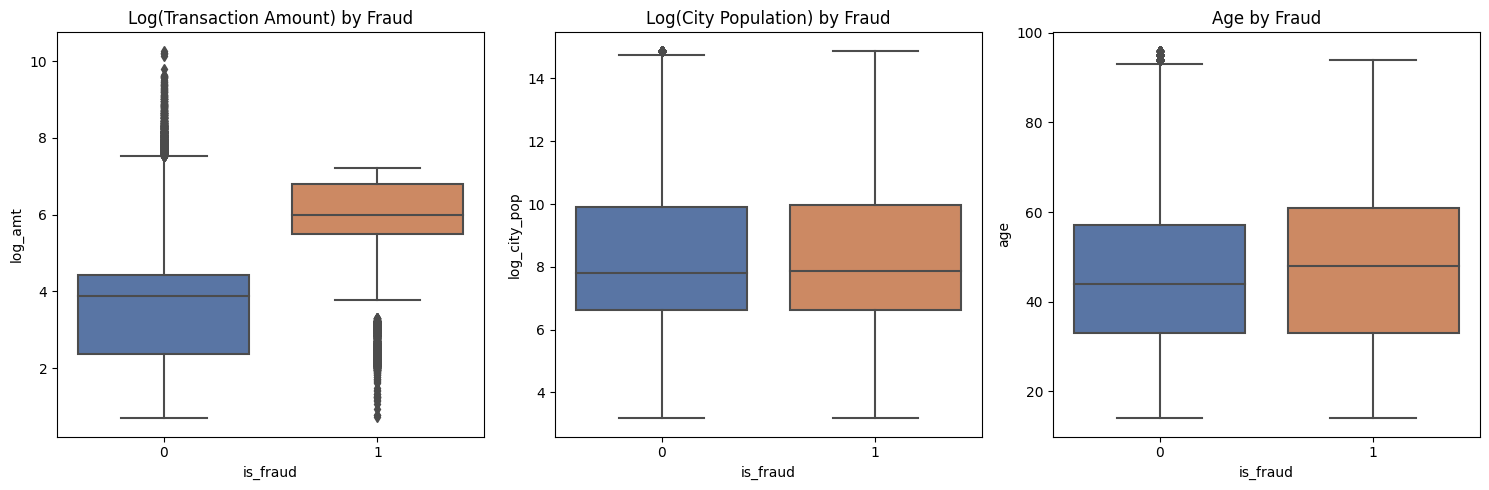

In [20]:
# Convert selected features to pandas for visualization
df_viz = df.select("log_amt", "city_pop", "dob", "trans_date_trans_time", "is_fraud") \
           .withColumn("trans_date", to_date("trans_date_trans_time")) \
           .withColumn("dob", to_date("dob")) \
           .withColumn("age", year("trans_date") - year("dob")) \
           .select("log_amt", "city_pop", "age", "is_fraud") \
           .dropna()

pdf = df_viz.toPandas()

# Apply log1p transformation to city_pop
pdf["log_city_pop"] = np.log1p(pdf["city_pop"])

# Create boxplots
plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

ax1 = plt.subplot(gs[0])
sns.boxplot(x="is_fraud", y="log_amt", data=pdf, ax=ax1)
ax1.set_title("Log(Transaction Amount) by Fraud")

ax2 = plt.subplot(gs[1])
sns.boxplot(x="is_fraud", y="log_city_pop", data=pdf, ax=ax2)
ax2.set_title("Log(City Population) by Fraud")

ax3 = plt.subplot(gs[2])
sns.boxplot(x="is_fraud", y="age", data=pdf, ax=ax3)
ax3.set_title("Age by Fraud")

plt.tight_layout()
plt.show()

### 12.2 Basic Cleaning and Feature Engineering

In this section, I reproduce the entire data cleaning and transformation pipeline using PySpark, following the logic implemented earlier in the `basic_cleaning()` and `preproc()` functions.

The goal is to prepare the dataset for modeling by deriving informative features, applying log transformations, encoding categorical variables, and ensuring a fully numeric format. These preprocessing steps are essential for handling skewness, reducing noise, and enabling machine learning algorithms to better distinguish between fraudulent and legitimate transactions.


#### 12.2.1 Feature Engineering in PySpark

This section replicates the logic of the `basic_cleaning()` function using PySpark. I apply transformations to derive new features such as age, time-based variables, customer–merchant distance, and behavioral patterns like transaction frequency and recency. These features will later be used for training the fraud detection model.


In [15]:
from pyspark.sql.functions import (
    to_date, year, datediff, current_date, hour, dayofweek, month,
    lag, count, mean, col, when, log1p, lit, unix_timestamp, min as spark_min, max as spark_max
)
from pyspark.sql.window import Window

# Keep only selected columns
cols_to_keep = [
    'trans_date_trans_time', 'amt', 'category', 'merchant',
    'gender', 'city_pop', 'job', 'dob', 'state', 'zip',
    'lat', 'long', 'merch_lat', 'merch_long', 'cc_num', 'is_fraud'
]
df_clean = df.select([col(c) for c in cols_to_keep])

# Convert to date and derive age
df_clean = df_clean.withColumn("trans_date", to_date("trans_date_trans_time")) \
                   .withColumn("dob", to_date("dob")) \
                   .withColumn("age", year("trans_date") - year("dob")) \
                   .drop("dob")

# Time features
df_clean = df_clean.withColumn("hour", hour("trans_date_trans_time")) \
                   .withColumn("day_of_week", dayofweek("trans_date_trans_time")) \
                   .withColumn("month", month("trans_date_trans_time")) \
                   .withColumn("date", to_date("trans_date_trans_time"))

# Haversine distance
from pyspark.sql.functions import radians, sin, cos, sqrt, atan2

R = 6371.0
df_clean = df_clean.withColumn("lat1", radians("lat")) \
                   .withColumn("lon1", radians("long")) \
                   .withColumn("lat2", radians("merch_lat")) \
                   .withColumn("lon2", radians("merch_long"))

df_clean = df_clean.withColumn("dlat", col("lat2") - col("lat1")) \
                   .withColumn("dlon", col("lon2") - col("lon1"))

a = (sin(col("dlat") / 2) ** 2) + cos(col("lat1")) * cos(col("lat2")) * (sin(col("dlon") / 2) ** 2)
c = 2 * atan2(sqrt(a), sqrt(1 - a))
df_clean = df_clean.withColumn("distance", R * c)

# Sort transactions for lag-based features
window_txn = Window.partitionBy("cc_num").orderBy("trans_date_trans_time")
df_clean = df_clean.withColumn("time_since_last_transaction",
                               (unix_timestamp("trans_date_trans_time") -
                                unix_timestamp(lag("trans_date_trans_time").over(window_txn)))
                               )

df_clean = df_clean.withColumn("distance_delta",
                               (col("distance") - lag("distance").over(window_txn)).cast("double"))

# Daily transaction count per user
window_day = Window.partitionBy("cc_num", "date")
df_clean = df_clean.withColumn("daily_txn_count", count("*").over(window_day))

# Time since first transaction today
df_clean = df_clean.withColumn("first_txn_today",
                               spark_min("trans_date_trans_time").over(window_day))
df_clean = df_clean.withColumn("time_since_first_txn_today",
                               (unix_timestamp("trans_date_trans_time") -
                                unix_timestamp("first_txn_today")))

# Average transaction amount per user
window_user = Window.partitionBy("cc_num")
df_clean = df_clean.withColumn("avg_amt_by_user", mean("amt").over(window_user))

# Relative amount to ZIP and State medians
window_zip = Window.partitionBy("zip")
window_state = Window.partitionBy("state")

df_clean = df_clean.withColumn("median_amt_zip", spark_min("amt").over(window_zip)) \
                   .withColumn("median_amt_state", spark_min("amt").over(window_state)) \
                   .withColumn("relative_amt_zip", col("amt") / col("median_amt_zip")) \
                   .withColumn("relative_amt_state", col("amt") / col("median_amt_state"))

# Merchant popularity (count)
window_merchant = Window.partitionBy("merchant")
df_clean = df_clean.withColumn("merchant_popularity", count("*").over(window_merchant))

# Merchant frequency per user
window_user_merchant = Window.partitionBy("cc_num", "merchant")
df_clean = df_clean.withColumn("merchant_freq", count("*").over(window_user_merchant))

# High-value transaction dummy
quantile_95 = df.approxQuantile("amt", [0.95], 0.01)[0]
df_clean = df_clean.withColumn("is_high_value", when(col("amt") > quantile_95, 1).otherwise(0))

# Known merchant dummy (based on duplicates)
from pyspark.sql.functions import monotonically_increasing_id
df_clean = df_clean.withColumn("row_id", monotonically_increasing_id())
df_clean = df_clean.withColumn("known_merchant",
                               when(
                                   lag("merchant").over(window_txn) == col("merchant"),
                                   1
                               ).otherwise(0))

# Drop helper columns
df_clean = df_clean.drop("lat1", "lon1", "lat2", "lon2", "dlat", "dlon", "first_txn_today", "trans_date", "date", "cc_num")

# Preview engineered dataset
df_clean.show(5)


25/07/04 16:17:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------------------+-----+-------------+--------------------+------+--------+-----------------+-----+-----+-------+--------+---------+----------+--------+---+----+-----------+-----+------------------+---------------------------+-------------------+---------------+--------------------------+-----------------+--------------+----------------+------------------+------------------+-------------------+-------------+-------------+------+--------------+
|trans_date_trans_time|  amt|     category|            merchant|gender|city_pop|              job|state|  zip|    lat|    long|merch_lat|merch_long|is_fraud|age|hour|day_of_week|month|          distance|time_since_last_transaction|     distance_delta|daily_txn_count|time_since_first_txn_today|  avg_amt_by_user|median_amt_zip|median_amt_state|  relative_amt_zip|relative_amt_state|merchant_popularity|merchant_freq|is_high_value|row_id|known_merchant|
+---------------------+-----+-------------+--------------------+------+--------+--------------

#### 12.2.2 Final Preprocessing for Modeling

This section mirrors the logic of the `preproc()` function. I perform final data preparation steps such as dropping redundant or low-importance features, applying log transformations, encoding categorical variables, and imputing missing values. These transformations ensure the dataset is fully numeric and ready for model training.

In [16]:
# === 1. Drop unwanted columns ===
drop_cols = [
    "zip", "lat", "long", "state",
    "merchant", "city",
    "gender", "job",
    "category", "category_clean", "known_merchant"
]

df_model = df_clean.drop(*[c for c in drop_cols if c in df_clean.columns])

# === 2. Log-transform skewed variables ===
for colname in ["amt", "city_pop"]:
    if colname in df_model.columns:
        df_model = df_model.withColumn(f"log_{colname}", log1p(col(colname)))
        df_model = df_model.drop(colname)

# === 3. Encode categorical variables ===
cat_cols = [field.name for field in df_model.schema.fields if field.dataType.simpleString() == "string"]
indexers = [StringIndexer(inputCol=colname, outputCol=colname + "_idx", handleInvalid="keep") for colname in cat_cols]
encoders = [OneHotEncoder(inputCol=colname + "_idx", outputCol=colname + "_ohe") for colname in cat_cols]

# === 4. Impute missing values with median for numeric columns ===
# Collect numeric columns
numeric_cols = [field.name for field in df_model.schema.fields if field.dataType.simpleString() in ["double", "int"]]

# Compute medians
medians = {}
for colname in numeric_cols:
    median_val = df_model.approxQuantile(colname, [0.5], 0.01)[0]
    medians[colname] = median_val

# Apply median imputation
for colname, median_val in medians.items():
    df_model = df_model.withColumn(colname, when(col(colname).isNull(), median_val).otherwise(col(colname)))

# === 5. Final check ===
print("Remaining string columns:", [colname for colname in df_model.columns if dict(df_model.dtypes)[colname] == "string"])
df_model.printSchema()

Remaining string columns: []
root
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: double (nullable = true)
 |-- age: double (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: double (nullable = true)
 |-- month: double (nullable = true)
 |-- distance: double (nullable = true)
 |-- time_since_last_transaction: long (nullable = true)
 |-- distance_delta: double (nullable = true)
 |-- daily_txn_count: long (nullable = false)
 |-- time_since_first_txn_today: long (nullable = true)
 |-- avg_amt_by_user: double (nullable = true)
 |-- median_amt_zip: double (nullable = true)
 |-- median_amt_state: double (nullable = true)
 |-- relative_amt_zip: double (nullable = true)
 |-- relative_amt_state: double (nullable = true)
 |-- merchant_popularity: long (nullable = false)
 |-- merchant_freq: long (nullable = false)
 |-- is_high_value: double (nullable = false)
 |-- row_id: